<a href="https://colab.research.google.com/github/Rivuozil/Skin-Cancer-Classification-for-Imbalanced-Datasets/blob/main/ASAN_EMB_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Global params


class Globals:
  # @markdown GCP project with GCS bucket of interest:
  gcp_project = 'mineral-liberty-429713-r0'  # @param

  # GCS bucket with data to read:
  gcs_bucket_name = 'asan_preprocessed_embeddings'  # @param

  # @markdown PAD Dataset files:
  # Metadata CSV from PAD dataset to read
  gcs_metadata_csv = '/content/metadata_asan.csv'  # @param

  # Images directory:
  gcs_images_dir = 'images' #@param

  # Column name to use for the small model
  label_column = 'labels'  # @param

  # Column to join the CSV to the images by path
  img_join_column = 'image_paths' # @param

  # @markdown If precomputed embeddings should be used:
  # When true, use precomputed embeddings instead of generating
  # from scratch.
  gcs_use_precomputed_embeddings = False  # @param {type: "boolean"}

  # Path to precomputed embeddings
  gcs_precomputed_embeddings = 'pad_dataset/precomputed/embeddings.npz'  # @param

  # Access Token for `gcs_bucket_name`.
  # Note: You can also manually create and set this
  #   by using `gcloud auth print-access-token` in your local
  #   environment.
  gcs_creds = None

  # @markdown ---
  # @markdown Vertex AI end-point configuration:
  vertex_endpoint_project_id = '132886652110'  # @param
  vertex_endpoint_id = '180'  # @param
  vertex_endpoint_location = 'us-central1'  # @param

  random_state = 3141
  embeddings_size = 6144
  # @markdown ---
  # @markdown Training Parameters--Adjust this to reduce or increase the training size as a % of total training:
  train_split_size = 0.8 # @param
  # Note: this variable sets the training split. We set it by default to 0.15 to show how effective the model is on a small amount of data. You can increase it to see how more data improves the accuracy.

  ###### Formed during execution:

  # Client for querying GCS
  gcs_storage_client = None

  # Bucket object for loading files
  gcs_bucket = None

  # pd.DataFrame for the loaded metadata_csv
  metadata_df_dir1 = None
  metadata_df_dir2 = None
  metadata_df_dir3 = None
  metadata_df_dir4 = None
  metadata_df = None


  # Dict from image path -> embedding
  embeddings = dict()

  # pd.DataFrames for training/validation data splits
  df_train = None
  df_validate = None

  # ML model
  model = None

In [ ]:
from google.colab import auth

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

In [ ]:
import datetime
import google.auth
import google.auth.transport.requests

Globals.gcs_creds, project = google.auth.default()


def initial_token_refresh():
  # Refresh credentials so an access token is available.
  auth_req = google.auth.transport.requests.Request()
  Globals.gcs_creds.refresh(auth_req)
  assert (
      Globals.gcs_creds.valid
  ), f'Unexpected error: GCS Credentials are invalid'
  time_until_expiry = (
      Globals.gcs_creds.expiry - datetime.datetime.utcnow()
  ).total_seconds() // 60
  print(
      'Token will expire at'
      f' {Globals.gcs_creds.expiry.strftime("%Y-%m-%d %H:%M:%S")} UTC'
      f' ({time_until_expiry} minutes)'
  )


initial_token_refresh()
print(Globals.gcs_creds)

Token will expire at 2024-08-18 07:11:31 UTC (59.0 minutes)


In [ ]:
# @title Imports

import collections
import copy
import hashlib
import io
import os
import subprocess
import textwrap
import time
from typing import List, Text
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tabulate
import tensorflow as tf
import torch
import torch.nn.init as init

from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score
from torch.utils.data import DataLoader, WeightedRandomSampler, BatchSampler, Sampler

In [ ]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed) #LYZ: Set Python's hash seed to ensure consistent hashing operations.
    np.random.seed(seed)#Set NumPy’s random seed
    torch.manual_seed(seed)#Set NumPy’s random seed
    torch.cuda.manual_seed(seed)#Set PyTorch's GPU random seed.
    torch.backends.cudnn.deterministic = True# Set to use deterministic algorithms when using CuDNN (GPU-accelerated deep learning library) to ensure repeatability of results.
    torch.backends.cudnn.benchmark = True #Set to enable performance optimization of CuDNN to run faster.

    #LYZ: The call of this function can ensure that operations involving randomness (such as parameter initialization, data enhancement, etc.) are repeatable in different runs of the code.

seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CPU" device.


In [ ]:
classes_to_int_asan = {'ak':0, 'bcc':1, 'dermatofibroma':2, 'hemangioma':3, 'intraepithelial carcinoma':4, 'lentigo':5, 'melanoma':6, 'nevus':7, 'pyogenic granuloma':8, 'scc':9, 'sebk':10,'wart':11}
int_to_classes_asan = {0:'ak', 1:'bcc', 2:'dermatofibroma', 3:'hemangioma', 4:'intraepithelial carcinoma', 5:'lentigo', 6:'melanoma', 7:'nevus', 8:'pyogenic granuloma', 9:'scc', 10:'sebk', 11:'wart'}

num_classes=len(int_to_classes_asan.keys())
embedding_dim=6144
batch_size=32
learning_rate=0.001
epochs=40

print(num_classes)

12


In [ ]:
from google.cloud import storage


def list_blobs(storage_client, bucket_name):
  """Helper to list blobs in a bucket (useful for debugging)."""
  blobs = storage_client.list_blobs(bucket_name)
  for blob in blobs:
    print(blob)


def load_dataset(bucket, csv_path, images_dir):
  """Loads the given CSV into a pd.DataFrame."""
  #images_dir=os.path.join(Globals.gcs_bucket_name,images_dir)
  df = pd.read_csv(Globals.gcs_metadata_csv)
  df['img_path'] = df[Globals.img_join_column].apply(lambda x: os.path.join(images_dir, x))
  #df['img_path'] = df['img_path'].replace('\\','/')
  return df


Globals.gcs_storage_client = storage.Client(Globals.gcp_project)
#list_blobs(Globals.gcs_storage_client, Globals.gcs_bucket_name)
Globals.gcs_bucket = Globals.gcs_storage_client.bucket(Globals.gcs_bucket_name)
print(f'Bucket: {Globals.gcs_bucket.name}')
Globals.metadata_df = load_dataset(
    Globals.gcs_bucket, Globals.gcs_metadata_csv, Globals.gcs_images_dir
)
Globals.all_col_vals = sorted(set(Globals.metadata_df[Globals.label_column]))

Bucket: asan_preprocessed_embeddings


In [ ]:
Globals.metadata_df

,Unnamed: 0,image_paths,labels,img_path
0,0,test/ak/prefix00.png,0,images/test/ak/prefix00.png
1,1,test/ak/prefix01.png,0,images/test/ak/prefix01.png
2,2,test/ak/prefix02.png,0,images/test/ak/prefix02.png
3,3,test/ak/prefix03.png,0,images/test/ak/prefix03.png
4,4,test/ak/prefix10.png,0,images/test/ak/prefix10.png
...,...,...,...,...
12205,12205,val/wart/prefix86.png,11,images/val/wart/prefix86.png
12206,12206,val/wart/prefix87.png,11,images/val/wart/prefix87.png
12207,12207,val/wart/prefix88.png,11,images/val/wart/prefix88.png
12208,12208,val/wart/prefix89.png,11,images/val/wart/prefix89.png


In [ ]:
# @title Helpers: call Vertex predict
from typing import List
from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf import struct_pb2

PredictionServiceClient = aiplatform.gapic.PredictionServiceClient


def create_prediction_service_client_and_endpoint_path():
  client_options = {
      'api_endpoint': (
          f'{Globals.vertex_endpoint_location}-aiplatform.googleapis.com'
      )
  }
  # Initialize client that will be used to create and send requests.
  # This client only needs to be created once, and can be reused for multiple
  # requests.
  client = PredictionServiceClient(client_options=client_options)
  endpoint_path = client.endpoint_path(
      project=Globals.vertex_endpoint_project_id,
      location=Globals.vertex_endpoint_location,
      endpoint=Globals.vertex_endpoint_id,
  )
  return client, endpoint_path


def get_prediction_instances(image_uris: List[str]):
  """Returns a list of JSON dicts to pass as Vertex PredictionService instances."""
  instances = []
  for image_uri in image_uris:
    instance_dict = {
        'bucket_name': Globals.gcs_bucket_name,
        'object_uri': image_uri,
        'bearer_token': Globals.gcs_creds.token,
    }
    instance = json_format.ParseDict(instance_dict, struct_pb2.Value())
    instances.append(instance)
  return instances


def predict(
    client: PredictionServiceClient, endpoint_path: str, image_uris: List[str]
):
  """Calls predict for a Vertex endpoint using the given image paths."""
  instances = get_prediction_instances(image_uris)
  parameters_dict = {}
  parameters = json_format.ParseDict(parameters_dict, struct_pb2.Value())

  return client.predict(
      endpoint=endpoint_path, instances=instances, parameters=parameters
  )

In [ ]:
%%time
#@title Example predict request
def run_single_predict_request(bucket_name, object_uri):
  client, endpoint_path = create_prediction_service_client_and_endpoint_path()
  assert Globals.gcs_creds.token, 'GCS Credential token is not valid. Re-run "Authenticate" section?'
  instance_dict = {
      'bucket_name': bucket_name,
      'object_uri': object_uri,
      'bearer_token': Globals.gcs_creds.token,
  }
  instance = json_format.ParseDict(instance_dict, struct_pb2.Value())
  instances = [instance]
  parameters_dict = {}
  parameters = json_format.ParseDict(parameters_dict, struct_pb2.Value())

  return client.predict(
      endpoint=endpoint_path, instances=instances, parameters=parameters
  )

# Example of how to run:
TEST_PREDICT_VAL = run_single_predict_request(
    bucket_name=Globals.gcs_bucket_name,
    object_uri='images/ISIC_2019_Training_Input_1/ISIC_0000000.jpg')

# Note: The embedding is in TEST_PREDICT_VAL.predictions
print(TEST_PREDICT_VAL.predictions)
print(TEST_PREDICT_VAL.deployed_model_id)
print(TEST_PREDICT_VAL.model)
print(TEST_PREDICT_VAL.model_display_name)
print(TEST_PREDICT_VAL.model_version_id)

NotFound: 404 {
    "error": "Object not found: gs://asan_embeddings/images/ISIC_2019_Training_Input_1/ISIC_0000000.jpg\n\t [[{{function_node map_while_body_972}}{{node map/while/ReadGCSBucket}}]]"
}

In [ ]:
total_time=0.0

In [ ]:
BATCH_COUNTER = collections.Counter()
#@title Generate embeddings concurrently

import concurrent.futures
import time

def refresh_credentials():
  # Refreshing is required b/c this can take longer than the typical 1-hr
  # timeout.
  auth_req = google.auth.transport.requests.Request()
  Globals.gcs_creds.refresh(auth_req)

def run_predict(client, endpoint_path, img_paths, batch_id=None):
  # Ensure the GCS token has not yet expired. Otherwise `predict`
  # returns `500 Internal Error`.
  if not Globals.gcs_creds.valid:
    refresh_credentials()
    if not Globals.gcs_creds.valid:
      print('GCP Credentials are not valid.')
      return (None, None)
  start = time.time()
  try:
    predictions = predict(client, endpoint_path, img_paths)
  except Exception as e:
    print(f'Error generating embedding for {img_paths}: {e}')
    return (None, None)

  end = time.time()
  return (zip(img_paths, predictions.predictions), end-start, batch_id)


def generate_embeddings_concurrently(df, batch_size=1, num_workers=5):
  """Calls the API to compute embeddings for all images with no embedding yet."""
  # Generate batches of image paths to run the `predict` function with
  all_path_args = []
  for batch_start in np.arange(0, len(df), batch_size):
    batch_df = df.iloc[batch_start:batch_start+batch_size]
    img_paths = list(batch_df['img_path'])
    skip_iteration = True
    for img_path in img_paths:
      if img_path not in Globals.embeddings:
        skip_iteration = False
        break
    if skip_iteration:
      print(f'(skipped) {batch_start}')
      continue
    all_path_args.append(img_paths)

  client, endpoint_path = create_prediction_service_client_and_endpoint_path()
  total_embeddings = 0

  # Concurrently run `predict` requests for all image paths.
  overall_start = time.time()
  batch_counter = collections.Counter()
  with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = [executor.submit(run_predict, client, endpoint_path, arg, batch_id=i) for i, arg in enumerate(all_path_args)]
    for future in concurrent.futures.as_completed(futures):
      preds, batch_time, batch_id = future.result()
      if preds is not None:
        print(f'{batch_id}: {batch_time}')
        batch_counter[int(batch_time)] += 1
        BATCH_COUNTER[int(batch_time)] += 1
        for img_path, pred in preds:
          Globals.embeddings[img_path] = pred
          total_embeddings += 1
  overall_end = time.time()
  print(f'Total embeddings retrieved: {total_embeddings}')
  print(f'Total time: {overall_end-overall_start}s ({overall_end-overall_start/60.0:.1f})')
  #total_time+=overall_end-overall_start
  return batch_counter

REQUEST_TIMES = None
if Globals.gcs_use_precomputed_embeddings:
  print(f'WARNING: Skipping calculating embeddings. Precomputed embeddings will be used instead.')
if not Globals.gcs_use_precomputed_embeddings:
  # Note: You can scale up the number of workers after ~10m of making a high
  # volume of API calls.
  REQUEST_TIMES = generate_embeddings_concurrently(Globals.metadata_df)

'''
  # Example dictionary
my_dict = Globals.embeddings

# Define the file path in the Colab environment
file_path = '/content/drive/MyDrive/Swarnava/isic_embeddings_1.json'

# Save the dictionary to a JSON file
with open(file_path, 'w') as f:
    json.dump(my_dict, f)

# Define the destination path in your Google Drive
drive_path = '/content/drive/MyDrive/Swarnava/isic_embeddings.json'

# Move the file to Google Drive
!cp /content/my_dict.json "$drive_path"
'''

Streaming output truncated to the last 5000 lines.
(skipped) 7212
(skipped) 7213
(skipped) 7214
(skipped) 7215
(skipped) 7216
(skipped) 7217
(skipped) 7218
(skipped) 7219
(skipped) 7220
(skipped) 7221
(skipped) 7222
(skipped) 7223
(skipped) 7224
(skipped) 7225
(skipped) 7226
(skipped) 7227
(skipped) 7228
(skipped) 7229
(skipped) 7230
(skipped) 7231
(skipped) 7232
(skipped) 7233
(skipped) 7234
(skipped) 7235
(skipped) 7236
(skipped) 7237
(skipped) 7238
(skipped) 7239
(skipped) 7240
(skipped) 7241
(skipped) 7242
(skipped) 7243
(skipped) 7244
(skipped) 7245
(skipped) 7246
(skipped) 7247
(skipped) 7248
(skipped) 7249
(skipped) 7250
(skipped) 7251
(skipped) 7252
(skipped) 7253
(skipped) 7254
(skipped) 7255
(skipped) 7256
(skipped) 7257
(skipped) 7258
(skipped) 7259
(skipped) 7260
(skipped) 7261
(skipped) 7262
(skipped) 7263
(skipped) 7264
(skipped) 7265
(skipped) 7266
(skipped) 7267
(skipped) 7268
(skipped) 7269
(skipped) 7270
(skipped) 7271
(skipped) 7272
(skipped) 7273
(skipped) 7274
(ski

'\n  # Example dictionary\nmy_dict = Globals.embeddings\n\n# Define the file path in the Colab environment\nfile_path = \'/content/drive/MyDrive/Swarnava/isic_embeddings_1.json\'\n\n# Save the dictionary to a JSON file\nwith open(file_path, \'w\') as f:\n    json.dump(my_dict, f)\n\n# Define the destination path in your Google Drive\ndrive_path = \'/content/drive/MyDrive/Swarnava/isic_embeddings.json\'\n\n# Move the file to Google Drive\n!cp /content/my_dict.json "$drive_path"\n'

In [ ]:
import json
import numpy as np
from google.protobuf.json_format import MessageToDict

my_dict = Globals.embeddings

# Define the file path in the Colab environment
file_path = '/content/drive/MyDrive/Swarnava/asan_embeddings.json'

# Convert RepeatedComposite objects to NumPy arrays

for key, value in my_dict.items():
    my_dict[key]=list(value)

# Save the dictionary to a JSON file
with open(file_path, 'w') as f:
    json.dump(my_dict, f)

In [ ]:
#file_path1='/content/drive/MyDrive/Swarnava/{imagesISIC_2019_Training_Input_1IS.txt'
#file_path2='/content/drive/MyDrive/Swarnava/{imagesISIC_2019_Training_Input_2IS.txt'
#file_path3='/content/drive/MyDrive/Swarnava/{imagesISIC_2019_Training_Input_3IS.txt'
file_path='/content/drive/MyDrive/Swarnava/asan_embeddings.json'
'''
with open(file_path1, 'r', encoding='utf-8') as file:
    data_1=file.read()

data_1=json.loads(data_1)
print(data_1.keys())
with open(file_path2, 'r', encoding='utf-8') as file:
    data_2=file.read()

data_2=json.loads(data_2)
print(data_2.keys())
with open(file_path3, 'r', encoding='utf-8') as file:
    data_3=file.read()

data_3=json.loads(data_3)
print(data_3.keys())
'''
with open(file_path, 'r') as file:
    data=json.load(file)




embeddings_map=data.copy()

#embeddings_map.update(data_2)
#embeddings_map.update(data_3)
#embeddings_map.update(data_4)







In [ ]:
for val in embeddings_map.values():
    print(val)
    print(len(val))
    break

[0.103470646, 0.0, 0.00694754161, 2.66399384, 0.0271161981, 0.0, 0.00593932718, 0.162476674, 0.0835940838, 0.0056908112, 0.367756814, 0.0484421402, 0.00509860879, 0.0129868845, 0.0, 0.0, 0.0291611627, 0.0, 0.0, 0.0250588059, 0.179565147, 0.516032279, 0.0, 0.0, 0.0589317, 0.0, 0.0, 0.0, 0.0171000622, 0.0797495544, 0.229444787, 0.0897430107, 0.277022034, 0.379612714, 0.0, 0.0, 0.0, 0.0239290111, 0.00698976405, 0.0, 0.0, 0.0, 0.062078435, 0.0953352898, 0.0248426404, 0.0, 0.0, 0.183862835, 0.0, 0.000682869286, 0.445797086, 0.0, 0.00264878478, 1.06149, 0.0, 0.0, 0.0, 0.0, 0.10348957, 1.01279497, 0.0, 0.0, 0.063397482, 0.016935844, 0.0, 0.0162288863, 0.231268048, 0.0, 0.0, 0.169077694, 0.162381962, 0.704488754, 0.109520569, 0.00644211238, 0.0233057123, 0.0, 0.0, 0.0139901899, 0.00794086605, 1.2276566, 0.0, 0.00944313593, 0.183018863, 0.000250257319, 0.0, 0.00569033111, 0.0302225798, 0.0, 0.0, 0.0, 0.0843993947, 0.0, 0.354619384, 0.180700555, 0.56630981, 0.0990364254, 0.0481169894, 0.12380590

In [ ]:
missed_images=[]

for i in range(12210):
    if(Globals.metadata_df['img_path'][i] not in data.keys()):
        missed_images.append(Globals.metadata_df['image_paths'][i])


print(len(missed_images))

0


In [ ]:
missing_metadata_df=Globals.metadata_df[Globals.metadata_df['img_path'].isin(missed_images)]

In [ ]:
missing_embeddings=Globals.embeddings
embeddings_map.update(missing_embeddings)

In [ ]:
# Check that we have an embedding for every image
if len(embeddings_map.keys()) < len(Globals.metadata_df):
  raise ValueError(
      f'Expected {len(Globals.metadata_df)} embeddings to be present. '
      f'Got {len(embeddings_map.keys())}.\n'
      'Maybe the "Generate embeddings" cell should be run again? This can '
      'happen if there are intermittent API errors.'
  )

In [ ]:
class_data_melanoma=Globals.metadata_df[Globals.metadata_df["labels"]==0]
class_data_melanoma

,Unnamed: 0,image_paths,labels,img_path
0,0,test/ak/prefix00.png,0,images/test/ak/prefix00.png
1,1,test/ak/prefix01.png,0,images/test/ak/prefix01.png
2,2,test/ak/prefix02.png,0,images/test/ak/prefix02.png
3,3,test/ak/prefix03.png,0,images/test/ak/prefix03.png
4,4,test/ak/prefix10.png,0,images/test/ak/prefix10.png
...,...,...,...,...
11174,11174,val/ak/prefix31.png,0,images/val/ak/prefix31.png
11175,11175,val/ak/prefix32.png,0,images/val/ak/prefix32.png
11176,11176,val/ak/prefix33.png,0,images/val/ak/prefix33.png
11177,11177,val/ak/prefix34.png,0,images/val/ak/prefix34.png


In [ ]:
seed=42

from sklearn.model_selection import train_test_split
data=Globals.metadata_df
test_data=pd.DataFrame(columns=Globals.metadata_df.columns)


for class_idx in int_to_classes_asan.keys():
    print(class_idx)
    class_data=Globals.metadata_df[Globals.metadata_df["labels"]==class_idx]
    train_valid_split, test_split=train_test_split(class_data, test_size=0.2, stratify=class_data['labels'], random_state=seed)
    test_data=pd.concat([test_data, test_split])

data=data[~data["image_paths"].isin(test_data["image_paths"])]

train_split,validation_split=train_test_split(data, test_size=0.2, stratify=data["labels"], random_state=seed)
train_split, calib_split=train_test_split(train_split, test_size=0.1, stratify=train_split["labels"], random_state=seed)

train_split.reset_index(drop=True, inplace=True)
validation_split.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
calib_split.reset_index(drop=True, inplace=True)

print(len(train_split))
print(len(validation_split))
print(len(test_data))
print(len(calib_split))

0
1
2
3
4
5
6
7
8
9
10
11
7029
1953
2447
781


In [ ]:
from sklearn.model_selection import train_test_split
seed=42

train_split=Globals.metadata_df[Globals.metadata_df['img_path'].str.contains('train')]
validation_split=Globals.metadata_df[Globals.metadata_df['img_path'].str.contains('val')]
test_data=Globals.metadata_df[Globals.metadata_df['img_path'].str.contains('test')]

train_split, calib_split=train_test_split(train_split, test_size=0.1, stratify=train_split["labels"], random_state=seed)

train_split.reset_index(drop=True, inplace=True)
validation_split.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
calib_split.reset_index(drop=True, inplace=True)

train_split=train_split[:len(train_split)-1]
print(len(train_split))
print(len(validation_split))
print(len(test_data))
print(len(calib_split))


8864
1086
1274
985


In [ ]:
test_data

,Unnamed: 0,image_paths,labels,img_path
0,0,test/ak/prefix00.png,0,images/test/ak/prefix00.png
1,1,test/ak/prefix01.png,0,images/test/ak/prefix01.png
2,2,test/ak/prefix02.png,0,images/test/ak/prefix02.png
3,3,test/ak/prefix03.png,0,images/test/ak/prefix03.png
4,4,test/ak/prefix10.png,0,images/test/ak/prefix10.png
...,...,...,...,...
1269,1269,test/wart/prefix95.png,11,images/test/wart/prefix95.png
1270,1270,test/wart/prefix96.png,11,images/test/wart/prefix96.png
1271,1271,test/wart/prefix97.png,11,images/test/wart/prefix97.png
1272,1272,test/wart/prefix98.png,11,images/test/wart/prefix98.png


In [ ]:
train_split.loc[train_split['img_path']=='images/ISIC_2019_Training_Input_4/ISIC_0063663.jpg']

,Unnamed: 0,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,labels,img_path
1640,19272,ISIC_0063663,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,images/ISIC_2019_Training_Input_4/ISIC_0063663...


In [ ]:
class embDataset(torch.utils.data.Dataset):
    def __init__(self, data, embeddings_map):
        self.data = data
        self.embeddings_map = embeddings_map

    def __len__(self):
        return len(self.data)

    def __getitem__(self, id):
        image_path = self.data["img_path"][id]
        parent_folder = image_path.split('/')[-2]


        # Retrieve the embedding for the image path
        emb = self.embeddings_map.get(image_path)
        if emb is None:
            raise ValueError(f"Embedding not found for {image_path}")

        emb = torch.tensor(emb, dtype=torch.float32)

        # Retrieve the label for the image path
        label = torch.as_tensor(
            self.data.loc[self.data["img_path"] == image_path, "labels"].item(),
            dtype=torch.int64
        )

        return emb, label

    def collate_fn(self, batch):
        # Filter out None values (if any)
        batch = [item for item in batch if item is not None]
        emb, labels = list(zip(*batch))
        emb = torch.stack(emb, dim=0).to(device)
        labels = torch.tensor(labels).to(device)
        return emb, labels

class smoteDataset(torch.utils.data.Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings= embeddings
        self.labels=labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, id):
        emb=self.embeddings[id]

        if emb is None:
            raise ValueError(f"Embedding not found for {id}")

        emb = torch.tensor(emb, dtype=torch.float32)

        # Retrieve the label for the image path
        label = torch.as_tensor(
            self.labels[id],
            dtype=torch.int64
        )

        return emb, label

    def collate_fn(self, batch):
        # Filter out None values (if any)
        batch = [item for item in batch if item is not None]
        emb, labels = list(zip(*batch))
        emb = torch.stack(emb, dim=0).to(device)
        labels = torch.tensor(labels).to(device)
        return emb, labels

class ClassDataset(torch.utils.data.Dataset):
    def __init__(self, data=None, labels=None):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        # load image and labels
        if self.data is not None:
            emb = torch.as_tensor(self.data[index], dtype=torch.float64)


        label = torch.as_tensor(self.labels[index], dtype=torch.int64)

        return emb,label

    def __len__(self):
        return len(self.data)

    def collate_fn(self, batch):
        # Filter out None values (if any)
        batch = [item for item in batch if item is not None]
        emb, labels = list(zip(*batch))
        emb = torch.stack(emb, dim=0).to(device)
        labels = torch.tensor(labels).to(device)
        return emb, labels
# Dataset and DataLoader setup
ISICEmbTrainSet = embDataset(train_split, embeddings_map)
ISICEmbValSet = embDataset(validation_split, embeddings_map)
ISICEmbTestSet = embDataset(test_data, embeddings_map)
ISICEmbCalibSet = embDataset(calib_split, embeddings_map)
#ASANEmbAugSet = smoteDataset(asan_resampled_embs, asan_resampled_labels)

ISICEmbTrainLoader = torch.utils.data.DataLoader(
    ISICEmbTrainSet, batch_size=batch_size, shuffle=True, collate_fn=ISICEmbTrainSet.collate_fn
)
ISICEmbValLoader = torch.utils.data.DataLoader(
    ISICEmbValSet, batch_size=batch_size, shuffle=False, collate_fn=ISICEmbValSet.collate_fn
)
ISICEmbCalibLoader = torch.utils.data.DataLoader(
    ISICEmbCalibSet, batch_size=1, shuffle=False, collate_fn=ISICEmbCalibSet.collate_fn
)
ISICEmbTestLoader = torch.utils.data.DataLoader(
    ISICEmbTestSet, batch_size=batch_size, shuffle=False, collate_fn=ISICEmbTestSet.collate_fn
)
ISICEmbTestLoader2 = torch.utils.data.DataLoader(
    ISICEmbTestSet, batch_size=1, shuffle=False, collate_fn=ISICEmbTestSet.collate_fn
)
#ASANEmbAugLoader = torch.utils.data.DataLoader(
#    ASANEmbAugSet, batch_size=batch_size, shuffle=True, collate_fn=ASANEmbAugSet.collate_fn
#)
# Test the DataLoader




In [ ]:
print(ISICEmbTrainSet.data)

      Unnamed: 0                                     image_paths  labels  \
0           2121                        train/bcc/prefix1721.png       1   
1           9840                       train/wart/prefix1285.png      11   
2           6088                      train/nevus/prefix1349.png       7   
3           3921                  train/hemangioma/prefix324.png       3   
4           4351  train/intraepithelial carcinoma/prefix1437.png       4   
...          ...                                             ...     ...   
8859        4390  train/intraepithelial carcinoma/prefix1536.png       4   
8860        7449                       train/nevus/prefix890.png       7   
8861        2653             train/dermatofibroma/prefix1049.png       2   
8862        2995             train/dermatofibroma/prefix1729.png       2   
8863        1421                         train/ak/prefix1515.png       0   

                                               img_path  
0                       image

In [ ]:
class_counts=train_split['labels'].value_counts()

print(class_counts)

labels
7     1310
11    1103
9      682
2      639
1      600
10     553
4      510
3      464
0      352
6      335
5      275
8      206
Name: count, dtype: int64


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
variance=0.90
pca=PCA(n_components=variance)
scaler=MinMaxScaler()
asan_embeddings=np.zeros((len(train_split),6144))
asan_labels=np.zeros(len(train_split)).astype(int)
index=0


for i in range(len(train_split)):
    asan_embeddings[index]=embeddings_map[train_split['img_path'][i]]
    asan_labels[index]=int(train_split['labels'][i])
    index+=1
#asan_reduced_embeddings=pca.fit_transform(asan_embeddings)
#asan_normalized_embeddings=scaler.fit_transform(asan_embeddings)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

asan_valid_embs=np.zeros((len(validation_split),6144))
asan_valid_labels=np.zeros(len(validation_split)).astype(int)
asan_test_embs=np.zeros((len(test_data),6144))
asan_test_labels=np.zeros(len(test_data)).astype(int)
asan_calib_embs=np.zeros((len(calib_split),6144))
asan_calib_labels=np.zeros(len(calib_split)).astype(int)
index=0

variance_test=207
pca=PCA(n_components=variance_test)
scaler=MinMaxScaler()

for i in range(len(validation_split)):
    asan_valid_embs[index]=embeddings_map[validation_split['img_path'][i]]
    asan_valid_labels[index]=int(validation_split['labels'][i])
    index+=1
index=0
for i in range(len(test_data)):
    asan_test_embs[index]=embeddings_map[test_data['img_path'][i]]
    asan_test_labels[index]=int(test_data['labels'][i])
    index+=1
index=0
for i in range(len(calib_split)):
    asan_calib_embs[index]=embeddings_map[calib_split['img_path'][i]]
    asan_calib_labels[index]=int(calib_split['labels'][i])
    index+=1
'''
asan_reduced_valid_embs=pca.fit_transform(asan_valid_embs)
asan_reduced_test_embs=pca.fit_transform(asan_test_embs)
asan_reduced_calib_embs=pca.fit_transform(asan_calib_embs)
asan_normalized_valid_embs=scaler.fit_transform(asan_valid_embs)
asan_normalized_calib_embs=scaler.fit_transform(asan_calib_embs)
asan_normalized_test_embs=scaler.fit_transform(asan_test_embs)
'''
'''
asan_reduced_valid_embs=np.array(asan_reduced_valid_embs.transform(asan_valid_embs))
asan_reduced_test_embs=np.array(asan_reduced_test_embs.transform(asan_test_embs))
asan_reduced_calib_embs=np.array(asan_reduced_calib_embs.transform(asan_calib_embs))'''

'\nasan_reduced_valid_embs=np.array(asan_reduced_valid_embs.transform(asan_valid_embs))\nasan_reduced_test_embs=np.array(asan_reduced_test_embs.transform(asan_test_embs))\nasan_reduced_calib_embs=np.array(asan_reduced_calib_embs.transform(asan_calib_embs))'

In [ ]:
print(asan_resampled_embs.dtype)

float64


In [ ]:
#asan_reduced_embeddings = np.array(asan_reduced_embeddings.transform(asan_embeddings))
print(asan_reduced_embs.shape)
print(asan_embeddings.shape)
print(asan_reduced_test_embs.shape)
print(asan_reduced_valid_embs.shape)

AttributeError: 'PCA' object has no attribute 'shape'

In [ ]:
from imblearn.over_sampling import SMOTE

smote1=SMOTE(sampling_strategy='auto', random_state=42)
asan_resampled_embs, asan_resampled_labels=smote1.fit_resample(asan_embeddings, asan_labels)
print(asan_resampled_embs.shape)
print(asan_resampled_labels.shape)

(15720, 6144)
(15720,)


In [ ]:
from sklearn.utils import resample

target_count_asan=350
train_split_undersampled=pd.DataFrame()
for class_idx, counts in class_counts.items():
    class_data = train_split[train_split["labels"] == class_idx]
    if(counts>=target_count_asan):
        class_data=resample(class_data, replace=False, n_samples=target_count_asan, random_state=42)
        train_split_undersampled=pd.concat([train_split_undersampled, class_data])

train_split_undersampled=pd.concat([train_split_undersampled, train_split[train_split["labels"]==8]])
train_split_undersampled.reset_index(drop=True, inplace=True)



In [ ]:
label_counts={i:0 for i in int_to_classes_asan.keys()}

for label in asan_resampled_labels:
    label_counts[label]+=1

print(label_counts)

{0: 1310, 1: 1310, 2: 1310, 3: 1310, 4: 1310, 5: 1310, 6: 1310, 7: 1310, 8: 1310, 9: 1310, 10: 1310, 11: 1310}


In [ ]:
class WeightSampler(Sampler):

    def __init__(self, data, weights):
        self.dataset=data
        self.weights=weights
        self.n=len(data)


    def __iter__(self):
        class_0_idxs=np.where(self.dataset.data['labels']==0)[0]
        class_1_idxs=np.where(self.dataset.data['labels']==1)[0]
        class_2_idxs=np.where(self.dataset.data['labels']==2)[0]
        class_3_idxs=np.where(self.dataset.data['labels']==3)[0]
        class_4_idxs=np.where(self.dataset.data['labels']==4)[0]
        class_5_idxs=np.where(self.dataset.data['labels']==5)[0]
        class_6_idxs=np.where(self.dataset.data['labels']==6)[0]
        class_7_idxs=np.where(self.dataset.data['labels']==7)[0]
        class_8_idxs=np.where(self.dataset.data['labels']==8)[0]
        class_9_idxs=np.where(self.dataset.data['labels']==9)[0]
        class_10_idxs=np.where(self.dataset.data['labels']==10)[0]
        class_11_idxs=np.where(self.dataset.data['labels']==11)[0]


        threshold = np.percentile(self.weights, 25)

        class_0=np.random.choice(class_0_idxs, size=int(self.n*self.weights[0]), replace=True) if self.weights[0]>threshold else class_0_idxs
        class_1=np.random.choice(class_1_idxs, size=int(self.n*self.weights[1]), replace=True) if self.weights[1]>threshold else class_1_idxs
        class_2=np.random.choice(class_2_idxs, size=int(self.n*self.weights[2]), replace=True) if self.weights[2]>threshold else class_2_idxs
        class_3=np.random.choice(class_3_idxs, size=int(self.n*self.weights[3]), replace=True) if self.weights[3]>threshold else class_3_idxs
        class_4=np.random.choice(class_4_idxs, size=int(self.n*self.weights[4]), replace=True) if self.weights[4]>threshold else class_4_idxs
        class_5=np.random.choice(class_5_idxs, size=int(self.n*self.weights[5]), replace=True) if self.weights[5]>threshold else class_5_idxs
        class_6=np.random.choice(class_6_idxs, size=int(self.n*self.weights[6]), replace=True) if self.weights[6]>threshold else class_6_idxs
        class_7=np.random.choice(class_7_idxs, size=int(self.n*self.weights[7]), replace=True) if self.weights[7]>threshold else class_7_idxs
        class_8=np.random.choice(class_8_idxs, size=int(self.n*self.weights[8]), replace=True) if self.weights[8]>threshold else class_8_idxs
        class_9=np.random.choice(class_9_idxs, size=int(self.n*self.weights[9]), replace=True) if self.weights[9]>threshold else class_9_idxs
        class_10=np.random.choice(class_10_idxs, size=int(self.n*self.weights[10]), replace=True) if self.weights[10]>threshold else class_10_idxs
        class_11=np.random.choice(class_11_idxs, size=int(self.n*self.weights[11]), replace=True) if self.weights[11]>threshold else class_11_idxs


        idxs=np.hstack([class_0, class_1, class_2, class_3, class_4, class_5, class_6, class_7, class_8, class_9, class_10, class_11])
        np.random.shuffle(idxs)
        idxs=idxs[:self.n]
        return iter(idxs)

    def __len__(self):
        return self.n



In [ ]:
# @title sklearn LogisticRegression model
from sklearn.linear_model import LogisticRegression
import torch.nn as nn
import torch.optim as optim

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.num_classes = num_classes
        self.fc1 = nn.Linear(input_dim, 2048)
        self.batchNorm1 = nn.BatchNorm1d(2048)
        self.relu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(2048, 1024)
        self.batchNorm2 = nn.BatchNorm1d(1024)
        self.relu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 512)
        self.batchNorm3 = nn.BatchNorm1d(512)
        self.relu3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(512, 256)
        self.batchNorm4 = nn.BatchNorm1d(256)
        self.relu4 = nn.ELU()
        self.dropout4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(256, 128)
        self.batchNorm5 = nn.BatchNorm1d(128)
        self.relu5 = nn.ELU()
        self.dropout5 = nn.Dropout(0.5)
        self.fc6 = nn.Linear(128,64)
        self.batchNorm6 = nn.BatchNorm1d(64)
        self.relu6 = nn.ELU()
        self.dropout6 = nn.Dropout(0.5)
        self.fc7 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.batchNorm1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.batchNorm2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.batchNorm3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.batchNorm4(x)
        x = self.dropout4(x)
        x = self.fc5(x)
        x = self.relu5(x)
        x = self.batchNorm5(x)
        x = self.dropout5(x)
        x = self.fc6(x)
        x = self.relu6(x)
        x = self.batchNorm6(x)
        x = self.dropout6(x)
        x = self.fc7(x)
        return x

class MLPwithSoftMax(nn.Module):
    def __init__(self,original_model):
        super(MLPwithSoftMax, self).__init__()
        self.base_model=original_model
        self.softmax=nn.Softmax(dim=1)

    def forward(self, x):
        x = self.base_model(x)
        x = self.softmax(x)
        return x

Globals.model=MLP(6144, num_classes)
softmax_model=MLPwithSoftMax(Globals.model).to(device)

def get_arch(input_dim, num_classes=12):
    return MLP(input_dim, num_classes)





In [ ]:
def calc_accuracy(y_pred, y_true):
    return (y_true == torch.max(y_pred, 1)[1]).float().mean()

In [ ]:
from sklearn.metrics import f1_score

def calc_f1(y_preds, y_true):

    f1 = f1_score(y_true.cpu(), y_preds.cpu(), average='macro')
    return f1

In [ ]:
def calc_f1_weights(preds, targets):

    true_positives = {i: 0 for i in range(num_classes)}
    false_positives = {i: 0 for i in range(num_classes)}
    false_negatives = {i: 0 for i in range(num_classes)}

    # Count TP, FP, FN for each class
    for pred, target in zip(preds, targets):
        if pred == target:
            true_positives[target] += 1
        else:
            false_positives[pred] += 1
            false_negatives[target] += 1
    print("tp:{}".format(true_positives))
    print("fp:{}".format(false_positives))
    print("fn:{}".format(false_negatives))
    # Calculate precision, recall, and F1-score for each class
    precision = {}
    recall = {}
    f1 = {}
    support = {}  # Number of true instances per class

    for class_id in range(num_classes):
        tp = true_positives[class_id]
        fp = false_positives[class_id]
        fn = false_negatives[class_id]
        support[class_id] = tp + fn

        if tp + fp > 0:
            precision[class_id] = tp / (tp + fp)
        else:
            precision[class_id] = 0.0

        if tp + fn > 0:
            recall[class_id] = tp / (tp + fn)
        else:
            recall[class_id] = 0.0

        if precision[class_id] + recall[class_id] > 0:
            f1[class_id] = 2 * (precision[class_id] * recall[class_id]) / (precision[class_id] + recall[class_id])
        else:
            f1[class_id] = 0.0

    # Calculate macro or weighted average F1-score
    #total_support = np.sum(list(support.values()))
    #f1_score = np.sum([f1[c] * support[c] / total_support for c in range(num_classes)])
    f1_sum=np.sum(list(f1.values()))
    f1_score=np.array(list(f1.values()))/f1_sum

    return f1_score


In [ ]:
def train_one_batch(data, model, criterion, optimizer):
    Globals.model.train()
    embs, labels = data


    optimizer.zero_grad()
    out = Globals.model(embs)
    loss = criterion(out, labels)

    loss.backward()
    optimizer.step()

    accuracy = calc_accuracy(out, labels).item()

    return loss.item(), accuracy

@torch.no_grad()
def validate_one_batch(data, model, criterion):
    Globals.model.eval()
    embs, labels = data

    out = Globals.model(embs)
    loss = criterion(out, labels)
    y_scores=torch.softmax(out, dim=1)
    y_preds=torch.argmax(out, dim=1)
    accuracy = calc_accuracy(out, labels)
    #auprc=np.array(calculate_auprc(y_scores, labels))
    return loss.item(), accuracy.item(), y_scores, y_preds, labels

In [ ]:

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, path='/content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        # Initialize best_loss if it's the first call
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)

        # Check if the validation loss has improved enough to consider a checkpoint
        elif self.best_loss - val_loss > self.min_delta:
            self.save_checkpoint(val_loss, model)
            self.best_loss = val_loss
            self.counter = 0  # Reset the counter if improvement is seen

        # If no improvement, increase the counter
        else:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        """Saves the model when the validation loss decreases."""
        torch.save(Globals.model.state_dict(), self.path)
        print(f'Model saved to: {self.path} with validation loss: {val_loss:.4f}')

In [ ]:
class_counts_asan=train_split['labels'].value_counts()
class_weights=[0]*num_classes
for class_idx, counts in class_counts_asan.items():
    class_weights[class_idx]=1/(counts/len(train_split))

class_counts_sum=sum(class_weights)
class_weights=[weight/class_counts_sum for weight in class_weights]
print(class_weights)
thre=np.percentile(class_weights, 60)
print(thre)

[0.10631707037157923, 0.06272144627741313, 0.058540016525585596, 0.08119420100295262, 0.07490902588582043, 0.13625693501644923, 0.1118335221361423, 0.028685670529778783, 0.1823746668681705, 0.05507248941431397, 0.06803072221768197, 0.03406423375411231]
0.07868013095609974


In [ ]:
params = {"num_classes": num_classes}

model = Globals.model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, min_lr=1e-7)
stopper = EarlyStopping(patience=5)
class_sampler=WeightSampler(ISICEmbTrainSet, class_weights)
ISICEmbTrainLoader = torch.utils.data.DataLoader(ISICEmbTrainSet, batch_size=batch_size, collate_fn=ISICEmbTrainSet.collate_fn, sampler=class_sampler)

In [ ]:
n_epochs=40
n_classes=6
lr=0.001
patience=5
min_lr=1e-6
wd=0.0001
model=Globals.model.to(device)
sampling= 'instance'
metric='f1'
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer,  mode='max', factor=0.1, patience=patience, min_lr=min_lr, verbose=False)

stopper=EarlyStopping(patience=5)
N_SAMPLES_PER_CLASS = [0] * num_classes
for c in range(len(np.unique(ISICEmbTrainSet.labels))):
        exs_train = np.count_nonzero(np.array(ISICEmbTrainSet.labels) == c)
        print(exs_train)
        #exs_val = np.count_nonzero(val_dataset.dr == c)
        #print('Found {:d} : {}'.format(exs_train,  c))
        N_SAMPLES_PER_CLASS[c] = exs_train
cls_num_list_cuda = torch.from_numpy(np.array(class_counts)).float().to(device)
#train_criterion, val_criterion = BalancedSoftmaxLoss(cls_num_list_cuda), BalancedSoftmaxLoss(cls_num_list_cuda)
train_criterion, val_criterion=nn.CrossEntropyLoss(),nn.CrossEntropyLoss()
do_mixup = 0.7
experiment_path='/content/drive/MyDrive/Swarnava'
n_checkpoints=1

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
print(model)

MLP(
  (fc1): Linear(in_features=207, out_features=2048, bias=True)
  (batchNorm1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): Swish()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (batchNorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): Swish()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (batchNorm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): Swish()
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (batchNorm4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): Swish()
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (batchNorm5): BatchNorm1d(128, eps=1e

In [ ]:
import tqdm

EPOCHS = 100
print_freq = 524
'''
best_loss, best_auc, best_bacc, best_k, best_mcc, best_f1, best_epoch, best_models = 10, 0, 0, 0, 0, 0, 0, []
vl_auc, vl_k, vl_mcc, vl_f1, vl_bacc, vl_auc_all, vl_f1_all, vl_acc_all = 0, 0, 0, 0, 0, [0 for _ in range(num_classes)], [0 for _ in range(num_classes)]
[0 for _ in range(num_classes)],  [0 for _ in range(num_classes)]
all_tr_aucs, all_vl_aucs, all_tr_mccs, all_vl_mccs = [], [], [], []
all_tr_ks, all_vl_ks, all_tr_baccs, all_vl_baccs, all_tr_losses, all_vl_losses = [], [], [], [], [], []
all_ts_ks, all_ts_baccs, all_ts_losses, all_ts_mccs, all_ts_aucs= [], [], [], [], []  '''
best_valid_loss = float('inf')  # 用于跟踪最佳验证损失
class_names=classes_to_int_asan.keys()

train_loss, train_accs = [0 for _ in range(num_classes)], [0 for _ in range(num_classes)]
valid_loss, valid_accs = [0 for _ in range(num_classes)], [0 for _ in range(num_classes)]
valid_f1=[0 for _ in range(num_classes)]
for epoch in range(1, EPOCHS+1):


    # code by LYZ:使用 tqdm 来显示训练循环的进度
    for step, batch in tqdm.tqdm(enumerate(ISICEmbTrainLoader, 1), total=len(ISICEmbTrainLoader)):
        time_1 = time.time()

        loss, accuracy = train_one_batch(batch, model, criterion, optimizer)

        train_loss.append(loss)
        train_accs.append(accuracy)


        if step % print_freq == 0:
            print('epoch:', epoch,
                '\tstep:', step, '/', len(ISICEmbTrainLoader),
                '\ttrain loss:', '{:.4f}'.format(loss),
                '\ttrain loss current ep:', '{:.4f}'.format(loss),
                '\ttrain accuracy:','{:.4f}'.format(accuracy),
                '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')



    valid_loss, valid_accs, valid_scores, valid_preds,valid_true = [], [], [], [], []
    for step, batch in enumerate(tqdm.tqdm(ISICEmbValLoader)):
        loss, accuracy, y_scores, y_preds, y_true = validate_one_batch(batch, model, criterion)

        valid_loss.append(loss)
        valid_accs.append(accuracy)
        valid_scores.append(y_scores)
        valid_true.append(y_true)
        valid_preds.append(y_preds)

    valid_scores=np.concatenate(valid_scores)
    valid_true=np.concatenate(valid_true)
    valid_preds=np.concatenate(valid_preds)
    f1_weights=calc_f1_weights(valid_preds, valid_true)
    weighted_sampler=WeightSampler(data=ISICEmbTrainSet, weights=f1_weights)
    ISICEmbTrainLoader=torch.utils.data.DataLoader(ISICEmbTrainSet, batch_size=batch_size, collate_fn=ISICEmbTrainSet.collate_fn,
                                                       sampler=weighted_sampler)
    print("f1 weights: {}".format(f1_weights))

    print('epoch:', epoch, '/', EPOCHS,
          '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
          '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
          '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
          '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))

       # code by LYZ:如果验证损失更低，则保存模型权重
    if np.mean(valid_loss) < best_valid_loss:
        best_valid_loss = np.mean(valid_loss)
        checkpoint_path = '/content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_PCA2.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Model weights saved to {checkpoint_path}')

    stopper(np.mean(valid_loss), model)
    scheduler.step(np.mean(valid_loss))

test_loss_isic, test_accs_isic = [], []
for step, batch in enumerate(tqdm.tqdm(ISICEmbTestLoader)):
    loss, accuracy = validate_one_batch(batch, model, criterion)

    test_loss_isic.append(loss)
    test_accs_isic.append(accuracy)

print('\ttest loss ISIC :', '{:.4f}'.format(np.mean(test_loss_isic)),
      '\ttest accuracy ISIC', '{:.4f}'.format(np.mean(test_accs_isic)))
'''
test_loss_asan, test_accs_asan = [], []
for step, batch in enumerate(tqdm(test_dl_2)):
    loss, accuracy = validate_one_batch(batch, model, criterion)

    test_loss_asan.append(loss)
    test_accs_asan.append(accuracy)

print('\ttest loss ASAN:', '{:.4f}'.format(np.mean(test_loss_asan)),
      '\ttest accuracy ASAN', '{:.4f}'.format(np.mean(test_accs_asan)))
'''

Metric: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Sampling probs: [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
Sample weights: [0.08333333 0.08333333 0.08333333 ... 0.08333333 0.08333333 0.08333333]
instance


  0%|          | 0/492 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'unsqueeze'

In [ ]:
for name, param in model.named_parameters():
    print(f"Parameter: {name}, Data type: {param.dtype}")

Parameter: fc1.weight, Data type: torch.float64
Parameter: fc1.bias, Data type: torch.float64
Parameter: batchNorm1.weight, Data type: torch.float64
Parameter: batchNorm1.bias, Data type: torch.float64
Parameter: fc2.weight, Data type: torch.float64
Parameter: fc2.bias, Data type: torch.float64
Parameter: batchNorm2.weight, Data type: torch.float64
Parameter: batchNorm2.bias, Data type: torch.float64
Parameter: fc3.weight, Data type: torch.float64
Parameter: fc3.bias, Data type: torch.float64
Parameter: batchNorm3.weight, Data type: torch.float64
Parameter: batchNorm3.bias, Data type: torch.float64
Parameter: fc4.weight, Data type: torch.float64
Parameter: fc4.bias, Data type: torch.float64
Parameter: batchNorm4.weight, Data type: torch.float64
Parameter: batchNorm4.bias, Data type: torch.float64
Parameter: fc5.weight, Data type: torch.float64
Parameter: fc5.bias, Data type: torch.float64
Parameter: batchNorm5.weight, Data type: torch.float64
Parameter: batchNorm5.bias, Data type: torc

In [ ]:
import tqdm

EPOCHS = 60
print_freq = 524


best_valid_loss_isic = float('inf')  # 用于跟踪最佳验证损失
best_valid_loss = float('inf')

for epoch in range(1, EPOCHS+1):


    train_loss, train_accs = [], []


    # code by LYZ:使用 tqdm 来显示训练循环的进度

    for step, batch in tqdm.tqdm(enumerate(ISICEmbTrainLoader, 1), total=len(ISICEmbTrainLoader)):
        time_1 = time.time()

        loss, accuracy = train_one_batch(batch, model, criterion, optimizer)

        train_loss.append(loss)
        train_accs.append(accuracy)


        if step % print_freq == 0:
            print('epoch:', epoch,
                '\tstep:', step, '/', len(ISICEmbTrainLoader),
                '\ttrain loss:', '{:.4f}'.format(loss),
                '\ttrain loss current ep:', '{:.4f}'.format(loss),
                '\ttrain accuracy:','{:.4f}'.format(accuracy),
                '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')



    valid_loss, valid_accs, valid_scores, valid_preds,valid_true = [], [], [], [], []
    for step, batch in enumerate(tqdm.tqdm(ISICEmbValLoader)):
        loss, accuracy, y_scores, y_preds, y_true = validate_one_batch(batch, model, criterion)

        valid_loss.append(loss)
        valid_accs.append(accuracy)
        valid_scores.append(y_scores)
        valid_true.append(y_true)
        valid_preds.append(y_preds)

    valid_scores=np.concatenate(valid_scores)
    valid_true=np.concatenate(valid_true)
    valid_preds=np.concatenate(valid_preds)
    f1_weights=calc_f1_weights(valid_preds, valid_true)
    weighted_sampler=WeightSampler(data=ISICEmbTrainSet, weights=f1_weights)
    ISICEmbTrainLoader=torch.utils.data.DataLoader(ISICEmbTrainSet, batch_size=batch_size, collate_fn=ISICEmbTrainSet.collate_fn,
                                                       sampler=weighted_sampler)
    print("f1 weights: {}".format(f1_weights))

    print('epoch:', epoch, '/', EPOCHS,
          '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
          '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
          '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
          '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))
    if np.mean(valid_loss) < best_valid_loss:
            best_valid_loss = np.mean(valid_loss)
            checkpoint_path = '/content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model weights saved to {checkpoint_path}')

    stopper(np.mean(valid_loss), model)
    scheduler.step(np.mean(valid_loss))



100%|██████████| 34/34 [00:01<00:00, 21.41it/s]


tp:{0: 44, 1: 10, 2: 73, 3: 9, 4: 0, 5: 36, 6: 39, 7: 182, 8: 30, 9: 63, 10: 9, 11: 124}
fp:{0: 66, 1: 1, 2: 16, 3: 1, 4: 0, 5: 23, 6: 35, 7: 89, 8: 56, 9: 100, 10: 1, 11: 79}
fn:{0: 11, 1: 83, 2: 22, 3: 63, 4: 78, 5: 6, 6: 13, 7: 22, 8: 2, 9: 43, 10: 77, 11: 47}
f1 weights: [0.09415624 0.03395057 0.140083   0.03875333 0.         0.1258524
 0.1092885  0.13528765 0.0897676  0.08269298 0.0331018  0.11706592]
epoch: 1 / 60 	train loss: 1.8923 	valid loss: 1.3678 	train accuracy 0.3982 	valid accuracy 0.5700
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth with validation loss: 1.3678


100%|██████████| 34/34 [00:01<00:00, 20.70it/s]


tp:{0: 42, 1: 57, 2: 84, 3: 5, 4: 9, 5: 37, 6: 43, 7: 167, 8: 29, 9: 68, 10: 34, 11: 113}
fp:{0: 40, 1: 20, 2: 51, 3: 0, 4: 5, 5: 20, 6: 31, 7: 58, 8: 44, 9: 68, 10: 22, 11: 39}
fn:{0: 13, 1: 36, 2: 11, 3: 67, 4: 69, 5: 5, 6: 9, 7: 37, 8: 3, 9: 38, 10: 52, 11: 58}
f1 weights: [0.08962468 0.09802229 0.10677027 0.01898358 0.02859918 0.10926106
 0.09976927 0.11380414 0.0807435  0.08214714 0.06999862 0.10227626]
epoch: 2 / 60 	train loss: 1.4898 	valid loss: 1.2064 	train accuracy 0.5505 	valid accuracy 0.6332
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth with validation loss: 1.2064


100%|██████████| 34/34 [00:01<00:00, 21.25it/s]


tp:{0: 35, 1: 72, 2: 79, 3: 24, 4: 27, 5: 36, 6: 38, 7: 169, 8: 24, 9: 64, 10: 45, 11: 114}
fp:{0: 31, 1: 39, 2: 38, 3: 5, 4: 14, 5: 24, 6: 19, 7: 46, 8: 26, 9: 48, 10: 28, 11: 41}
fn:{0: 20, 1: 21, 2: 16, 3: 48, 4: 51, 5: 6, 6: 14, 7: 35, 8: 8, 9: 42, 10: 41, 11: 57}
f1 weights: [0.07605535 0.09280031 0.0979802  0.06247942 0.05965734 0.09280031
 0.09166514 0.10605222 0.07695635 0.07719169 0.07441534 0.09194632]
epoch: 3 / 60 	train loss: 1.3727 	valid loss: 1.0525 	train accuracy 0.5794 	valid accuracy 0.6691
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth with validation loss: 1.0525


100%|██████████| 34/34 [00:01<00:00, 21.06it/s]


tp:{0: 38, 1: 74, 2: 80, 3: 28, 4: 37, 5: 35, 6: 45, 7: 173, 8: 27, 9: 61, 10: 48, 11: 108}
fp:{0: 35, 1: 37, 2: 25, 3: 10, 4: 23, 5: 10, 6: 30, 7: 49, 8: 30, 9: 28, 10: 31, 11: 24}
fn:{0: 17, 1: 19, 2: 15, 3: 44, 4: 41, 5: 7, 6: 7, 7: 31, 8: 5, 9: 45, 10: 38, 11: 63}
f1 weights: [0.07406044 0.09049284 0.0997867  0.06350063 0.06688601 0.10036018
 0.08839373 0.10130926 0.07568092 0.07803831 0.07257214 0.08891884]
epoch: 4 / 60 	train loss: 1.2514 	valid loss: 0.9912 	train accuracy 0.6205 	valid accuracy 0.6940
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth with validation loss: 0.9912


100%|██████████| 34/34 [00:01<00:00, 19.27it/s]


tp:{0: 33, 1: 68, 2: 77, 3: 30, 4: 37, 5: 39, 6: 40, 7: 173, 8: 27, 9: 65, 10: 57, 11: 112}
fp:{0: 20, 1: 32, 2: 21, 3: 11, 4: 26, 5: 27, 6: 22, 7: 47, 8: 26, 9: 26, 10: 41, 11: 29}
fn:{0: 22, 1: 25, 2: 18, 3: 42, 4: 41, 5: 3, 6: 12, 7: 31, 8: 5, 9: 41, 10: 29, 11: 59}
f1 weights: [0.07598787 0.0876205  0.09921733 0.06602325 0.06525845 0.08980385
 0.0872588  0.10146923 0.07899488 0.08205428 0.07703909 0.08927247]
epoch: 5 / 60 	train loss: 1.1484 	valid loss: 0.9517 	train accuracy 0.6537 	valid accuracy 0.6975
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth with validation loss: 0.9517


100%|██████████| 34/34 [00:01<00:00, 19.54it/s]


tp:{0: 31, 1: 69, 2: 80, 3: 37, 4: 49, 5: 39, 6: 42, 7: 165, 8: 25, 9: 73, 10: 61, 11: 103}
fp:{0: 15, 1: 18, 2: 21, 3: 25, 4: 43, 5: 24, 6: 14, 7: 37, 8: 22, 9: 26, 10: 48, 11: 19}
fn:{0: 24, 1: 24, 2: 15, 3: 35, 4: 29, 5: 3, 6: 10, 7: 39, 8: 7, 9: 33, 10: 25, 11: 68}
f1 weights: [0.07366785 0.0920056  0.09796515 0.06627269 0.06918068 0.08914828
 0.09333902 0.09754288 0.07595399 0.08546862 0.07508149 0.08437374]
epoch: 6 / 60 	train loss: 1.0903 	valid loss: 0.9310 	train accuracy 0.6732 	valid accuracy 0.7123
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth with validation loss: 0.9310


100%|██████████| 34/34 [00:01<00:00, 21.00it/s]


tp:{0: 36, 1: 66, 2: 80, 3: 41, 4: 50, 5: 37, 6: 40, 7: 160, 8: 26, 9: 73, 10: 55, 11: 110}
fp:{0: 22, 1: 20, 2: 22, 3: 21, 4: 39, 5: 22, 6: 19, 7: 31, 8: 19, 9: 36, 10: 39, 11: 22}
fn:{0: 19, 1: 27, 2: 15, 3: 31, 4: 28, 5: 5, 6: 12, 7: 44, 8: 6, 9: 33, 10: 31, 11: 61}
f1 weights: [0.0762836  0.08828726 0.09723686 0.07326325 0.07169035 0.08771775
 0.08628676 0.09699069 0.08085181 0.08130019 0.07316398 0.0869275 ]
epoch: 7 / 60 	train loss: 1.0308 	valid loss: 0.9360 	train accuracy 0.6885 	valid accuracy 0.7123
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 21.38it/s]


tp:{0: 38, 1: 65, 2: 79, 3: 42, 4: 47, 5: 38, 6: 41, 7: 161, 8: 24, 9: 81, 10: 60, 11: 112}
fp:{0: 25, 1: 20, 2: 22, 3: 24, 4: 28, 5: 19, 6: 14, 7: 30, 8: 10, 9: 40, 10: 43, 11: 23}
fn:{0: 17, 1: 28, 2: 16, 3: 30, 4: 31, 5: 4, 6: 11, 7: 43, 8: 8, 9: 25, 10: 26, 11: 59}
f1 weights: [0.07523541 0.08531278 0.09416549 0.07110349 0.07176739 0.08967453
 0.08952015 0.09522468 0.08495482 0.08336426 0.07416691 0.08551008]
epoch: 8 / 60 	train loss: 0.9890 	valid loss: 0.8694 	train accuracy 0.7054 	valid accuracy 0.7251
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth with validation loss: 0.8694


100%|██████████| 34/34 [00:01<00:00, 21.63it/s]


tp:{0: 24, 1: 76, 2: 81, 3: 45, 4: 38, 5: 38, 6: 39, 7: 156, 8: 24, 9: 81, 10: 60, 11: 111}
fp:{0: 18, 1: 28, 2: 18, 3: 30, 4: 35, 5: 12, 6: 10, 7: 25, 8: 20, 9: 51, 10: 46, 11: 20}
fn:{0: 31, 1: 17, 2: 14, 3: 27, 4: 40, 5: 4, 6: 13, 7: 48, 8: 8, 9: 25, 10: 26, 11: 60}
f1 weights: [0.05963335 0.09298161 0.10063128 0.07378106 0.06065357 0.09955097
 0.09306641 0.09765929 0.07611099 0.08202718 0.07531816 0.08858613]
epoch: 9 / 60 	train loss: 0.9304 	valid loss: 0.8926 	train accuracy 0.7249 	valid accuracy 0.7114
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 21.71it/s]


tp:{0: 26, 1: 74, 2: 79, 3: 37, 4: 47, 5: 40, 6: 37, 7: 168, 8: 25, 9: 75, 10: 54, 11: 129}
fp:{0: 14, 1: 28, 2: 14, 3: 19, 4: 34, 5: 25, 6: 11, 7: 30, 8: 17, 9: 40, 10: 28, 11: 35}
fn:{0: 29, 1: 19, 2: 16, 3: 35, 4: 31, 5: 2, 6: 15, 7: 36, 8: 7, 9: 31, 10: 32, 11: 42}
f1 weights: [0.06510874 0.09027899 0.0999675  0.0687672  0.07032185 0.08893358
 0.08802201 0.09941978 0.08037072 0.08073439 0.076467   0.09160823]
epoch: 10 / 60 	train loss: 0.8835 	valid loss: 0.8718 	train accuracy 0.7417 	valid accuracy 0.7281
INFO: Early stopping counter 2 of 5


100%|██████████| 34/34 [00:01<00:00, 21.17it/s]


tp:{0: 33, 1: 69, 2: 81, 3: 50, 4: 58, 5: 38, 6: 41, 7: 165, 8: 21, 9: 70, 10: 54, 11: 103}
fp:{0: 21, 1: 27, 2: 22, 3: 25, 4: 51, 5: 15, 6: 14, 7: 34, 8: 6, 9: 38, 10: 37, 11: 13}
fn:{0: 22, 1: 24, 2: 14, 3: 22, 4: 20, 5: 4, 6: 11, 7: 39, 8: 11, 9: 36, 10: 32, 11: 68}
f1 weights: [0.07095484 0.08556219 0.095877   0.07971632 0.07269106 0.0937464
 0.08980379 0.0959563  0.0834184  0.07666177 0.07150149 0.08411044]
epoch: 11 / 60 	train loss: 0.8598 	valid loss: 0.8751 	train accuracy 0.7410 	valid accuracy 0.7205
INFO: Early stopping counter 3 of 5


100%|██████████| 34/34 [00:01<00:00, 19.47it/s]


tp:{0: 27, 1: 76, 2: 76, 3: 42, 4: 53, 5: 37, 6: 42, 7: 159, 8: 27, 9: 72, 10: 60, 11: 104}
fp:{0: 16, 1: 29, 2: 15, 3: 30, 4: 51, 5: 10, 6: 14, 7: 31, 8: 22, 9: 39, 10: 41, 11: 13}
fn:{0: 28, 1: 17, 2: 19, 3: 30, 4: 25, 5: 5, 6: 10, 7: 45, 8: 5, 9: 34, 10: 26, 11: 67}
f1 weights: [0.0655026  0.09125764 0.09714523 0.0693438  0.06923494 0.09883995
 0.0924584  0.09594486 0.07925005 0.07888485 0.07628347 0.08585422]
epoch: 12 / 60 	train loss: 0.8162 	valid loss: 0.8670 	train accuracy 0.7535 	valid accuracy 0.7131
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth with validation loss: 0.8670


100%|██████████| 34/34 [00:01<00:00, 20.16it/s]


tp:{0: 27, 1: 76, 2: 79, 3: 45, 4: 49, 5: 37, 6: 37, 7: 172, 8: 25, 9: 69, 10: 55, 11: 124}
fp:{0: 18, 1: 30, 2: 14, 3: 13, 4: 38, 5: 22, 6: 12, 7: 29, 8: 15, 9: 34, 10: 37, 11: 29}
fn:{0: 28, 1: 17, 2: 16, 3: 27, 4: 29, 5: 5, 6: 15, 7: 32, 8: 7, 9: 37, 10: 31, 11: 47}
f1 weights: [0.06365401 0.09003731 0.09906751 0.0816077  0.07001226 0.08636591
 0.08636591 0.10012336 0.08185958 0.07783318 0.07284583 0.09022745]
epoch: 13 / 60 	train loss: 0.8110 	valid loss: 0.8115 	train accuracy 0.7555 	valid accuracy 0.7318
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth with validation loss: 0.8115


100%|██████████| 34/34 [00:01<00:00, 21.18it/s]


tp:{0: 22, 1: 81, 2: 80, 3: 50, 4: 54, 5: 36, 6: 43, 7: 173, 8: 24, 9: 68, 10: 56, 11: 118}
fp:{0: 6, 1: 39, 2: 18, 3: 18, 4: 49, 5: 11, 6: 17, 7: 39, 8: 6, 9: 26, 10: 32, 11: 20}
fn:{0: 33, 1: 12, 2: 15, 3: 22, 4: 24, 5: 6, 6: 9, 7: 31, 8: 8, 9: 38, 10: 30, 11: 53}
f1 weights: [0.06092728 0.08741231 0.09527959 0.08209357 0.06857761 0.09297789
 0.08825059 0.09559165 0.08897884 0.07815308 0.07397858 0.08777902]
epoch: 14 / 60 	train loss: 0.7547 	valid loss: 0.8277 	train accuracy 0.7716 	valid accuracy 0.7407
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 21.40it/s]


tp:{0: 28, 1: 81, 2: 77, 3: 50, 4: 50, 5: 37, 6: 40, 7: 181, 8: 27, 9: 75, 10: 52, 11: 117}
fp:{0: 21, 1: 31, 2: 14, 3: 17, 4: 27, 5: 20, 6: 9, 7: 44, 8: 14, 9: 29, 10: 24, 11: 21}
fn:{0: 27, 1: 12, 2: 18, 3: 22, 4: 28, 5: 5, 6: 12, 7: 23, 8: 5, 9: 31, 10: 34, 11: 54}
f1 weights: [0.061483   0.09023219 0.09453837 0.08214583 0.07366626 0.08534869
 0.09044175 0.09634998 0.08446392 0.08155908 0.07330248 0.08646846]
epoch: 15 / 60 	train loss: 0.7305 	valid loss: 0.8103 	train accuracy 0.7840 	valid accuracy 0.7501
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth with validation loss: 0.8103


100%|██████████| 34/34 [00:01<00:00, 20.77it/s]


tp:{0: 26, 1: 77, 2: 78, 3: 52, 4: 54, 5: 38, 6: 42, 7: 172, 8: 22, 9: 67, 10: 61, 11: 109}
fp:{0: 18, 1: 23, 2: 14, 3: 25, 4: 53, 5: 14, 6: 11, 7: 37, 8: 5, 9: 29, 10: 40, 11: 19}
fn:{0: 29, 1: 16, 2: 17, 3: 20, 4: 24, 5: 4, 6: 10, 7: 32, 8: 10, 9: 39, 10: 25, 11: 62}
f1 weights: [0.06057404 0.09201991 0.09620583 0.08049436 0.06732408 0.0932404
 0.09225892 0.09605651 0.08600408 0.07650183 0.07523789 0.08408213]
epoch: 16 / 60 	train loss: 0.6846 	valid loss: 0.8481 	train accuracy 0.7951 	valid accuracy 0.7344
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 19.15it/s]


tp:{0: 28, 1: 71, 2: 83, 3: 44, 4: 53, 5: 38, 6: 43, 7: 157, 8: 25, 9: 79, 10: 52, 11: 107}
fp:{0: 19, 1: 25, 2: 33, 3: 16, 4: 36, 5: 30, 6: 12, 7: 30, 8: 16, 9: 50, 10: 27, 11: 12}
fn:{0: 27, 1: 22, 2: 12, 3: 28, 4: 25, 5: 4, 6: 9, 7: 47, 8: 7, 9: 27, 10: 34, 11: 64}
f1 weights: [0.06526863 0.08931886 0.09352814 0.07925477 0.07545813 0.08213676
 0.09555014 0.09547057 0.08142613 0.07992927 0.07493178 0.08772683]
epoch: 17 / 60 	train loss: 0.6544 	valid loss: 0.8933 	train accuracy 0.8048 	valid accuracy 0.7177
INFO: Early stopping counter 2 of 5


100%|██████████| 34/34 [00:01<00:00, 18.31it/s]


tp:{0: 29, 1: 79, 2: 79, 3: 47, 4: 48, 5: 34, 6: 39, 7: 163, 8: 24, 9: 79, 10: 63, 11: 114}
fp:{0: 25, 1: 25, 2: 13, 3: 24, 4: 32, 5: 12, 6: 10, 7: 32, 8: 17, 9: 36, 10: 42, 11: 20}
fn:{0: 26, 1: 14, 2: 16, 3: 25, 4: 30, 5: 8, 6: 13, 7: 41, 8: 8, 9: 27, 10: 23, 11: 57}
f1 weights: [0.06197604 0.09341427 0.09840968 0.07656216 0.07076793 0.09000126
 0.08994884 0.09516277 0.07658447 0.08326973 0.07683508 0.08706776]
epoch: 18 / 60 	train loss: 0.6401 	valid loss: 0.8080 	train accuracy 0.8062 	valid accuracy 0.7344
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth with validation loss: 0.8080


100%|██████████| 34/34 [00:01<00:00, 20.05it/s]


tp:{0: 30, 1: 78, 2: 72, 3: 48, 4: 48, 5: 37, 6: 42, 7: 174, 8: 23, 9: 78, 10: 51, 11: 114}
fp:{0: 22, 1: 23, 2: 13, 3: 24, 4: 33, 5: 16, 6: 15, 7: 39, 8: 10, 9: 41, 10: 29, 11: 26}
fn:{0: 25, 1: 15, 2: 23, 3: 24, 4: 30, 5: 5, 6: 10, 7: 30, 8: 9, 9: 28, 10: 35, 11: 57}
f1 weights: [0.06544646 0.09385158 0.09337029 0.07780857 0.07046814 0.09091318
 0.08994386 0.09740066 0.08259679 0.08092092 0.07171513 0.08556441]
epoch: 19 / 60 	train loss: 0.6387 	valid loss: 0.8350 	train accuracy 0.8099 	valid accuracy 0.7316
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 21.76it/s]


tp:{0: 29, 1: 80, 2: 80, 3: 54, 4: 50, 5: 35, 6: 41, 7: 170, 8: 26, 9: 71, 10: 50, 11: 117}
fp:{0: 24, 1: 24, 2: 17, 3: 27, 4: 33, 5: 20, 6: 20, 7: 31, 8: 8, 9: 36, 10: 20, 11: 23}
fn:{0: 26, 1: 13, 2: 15, 3: 18, 4: 28, 5: 7, 6: 11, 7: 34, 8: 6, 9: 35, 10: 36, 11: 54}
f1 weights: [0.06212575 0.09395527 0.09640202 0.08165818 0.07185244 0.08348216
 0.08394654 0.09711611 0.09114373 0.07712162 0.0741554  0.08704079]
epoch: 20 / 60 	train loss: 0.6145 	valid loss: 0.8342 	train accuracy 0.8197 	valid accuracy 0.7389
INFO: Early stopping counter 2 of 5


100%|██████████| 34/34 [00:01<00:00, 21.65it/s]


tp:{0: 31, 1: 78, 2: 78, 3: 54, 4: 51, 5: 36, 6: 42, 7: 158, 8: 27, 9: 71, 10: 65, 11: 110}
fp:{0: 25, 1: 22, 2: 15, 3: 25, 4: 42, 5: 11, 6: 12, 7: 19, 8: 10, 9: 36, 10: 51, 11: 17}
fn:{0: 24, 1: 15, 2: 17, 3: 18, 4: 27, 5: 6, 6: 10, 7: 46, 8: 5, 9: 35, 10: 21, 11: 61}
f1 weights: [0.06368757 0.09216229 0.09461341 0.08155165 0.0680127  0.09224195
 0.0903565  0.09456884 0.08923406 0.0760142  0.07338004 0.08417679]
epoch: 21 / 60 	train loss: 0.6054 	valid loss: 0.8409 	train accuracy 0.8186 	valid accuracy 0.7371
INFO: Early stopping counter 3 of 5


100%|██████████| 34/34 [00:01<00:00, 21.20it/s]


tp:{0: 24, 1: 79, 2: 77, 3: 57, 4: 46, 5: 37, 6: 36, 7: 156, 8: 24, 9: 75, 10: 59, 11: 130}
fp:{0: 18, 1: 21, 2: 17, 3: 38, 4: 29, 5: 23, 6: 7, 7: 23, 8: 7, 9: 36, 10: 35, 11: 32}
fn:{0: 31, 1: 14, 2: 18, 3: 15, 4: 32, 5: 5, 6: 16, 7: 48, 8: 8, 9: 31, 10: 27, 11: 41}
f1 weights: [0.05754185 0.095195   0.0947487  0.07937847 0.0699215  0.08436181
 0.08812989 0.09472621 0.08859619 0.08037961 0.07622964 0.09079114]
epoch: 22 / 60 	train loss: 0.5497 	valid loss: 0.8384 	train accuracy 0.8387 	valid accuracy 0.7363
INFO: Early stopping counter 4 of 5


100%|██████████| 34/34 [00:01<00:00, 20.73it/s]


tp:{0: 28, 1: 79, 2: 79, 3: 54, 4: 49, 5: 36, 6: 41, 7: 169, 8: 26, 9: 69, 10: 63, 11: 112}
fp:{0: 16, 1: 23, 2: 18, 3: 25, 4: 39, 5: 17, 6: 11, 7: 27, 8: 7, 9: 39, 10: 39, 11: 20}
fn:{0: 27, 1: 14, 2: 16, 3: 18, 4: 29, 5: 6, 6: 11, 7: 35, 8: 6, 9: 37, 10: 23, 11: 59}
f1 weights: [0.06464554 0.0925994  0.09404627 0.0817396  0.06746891 0.0866153
 0.0901086  0.09657004 0.09142726 0.07369721 0.07659464 0.08448724]
epoch: 23 / 60 	train loss: 0.5168 	valid loss: 0.8256 	train accuracy 0.8476 	valid accuracy 0.7408
INFO: Early stopping counter 5 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 20.96it/s]


tp:{0: 27, 1: 82, 2: 80, 3: 56, 4: 47, 5: 36, 6: 42, 7: 172, 8: 23, 9: 78, 10: 61, 11: 125}
fp:{0: 13, 1: 25, 2: 19, 3: 20, 4: 32, 5: 14, 6: 8, 7: 25, 8: 6, 9: 42, 10: 31, 11: 22}
fn:{0: 28, 1: 11, 2: 15, 3: 16, 4: 31, 5: 6, 6: 10, 7: 32, 8: 9, 9: 28, 10: 25, 11: 46}
f1 weights: [0.06352095 0.09163485 0.0921648  0.08456743 0.06690754 0.08745638
 0.09202926 0.09586518 0.08427036 0.07713704 0.07659257 0.08785363]
epoch: 24 / 60 	train loss: 0.4913 	valid loss: 0.7850 	train accuracy 0.8553 	valid accuracy 0.7631
Model weights saved to /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth
Model saved to: /content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth with validation loss: 0.7850


100%|██████████| 34/34 [00:01<00:00, 20.91it/s]


tp:{0: 29, 1: 81, 2: 83, 3: 53, 4: 48, 5: 34, 6: 43, 7: 166, 8: 24, 9: 76, 10: 63, 11: 121}
fp:{0: 22, 1: 26, 2: 22, 3: 14, 4: 33, 5: 11, 6: 7, 7: 22, 8: 7, 9: 37, 10: 41, 11: 23}
fn:{0: 26, 1: 12, 2: 12, 3: 19, 4: 30, 5: 8, 6: 9, 7: 38, 8: 8, 9: 30, 10: 23, 11: 50}
f1 weights: [0.06139284 0.09088258 0.09312659 0.08556314 0.06774383 0.08769711
 0.0946006  0.09502714 0.08548626 0.07787447 0.07440679 0.08619865]
epoch: 25 / 60 	train loss: 0.4802 	valid loss: 0.7895 	train accuracy 0.8594 	valid accuracy 0.7556
INFO: Early stopping counter 1 of 5


100%|██████████| 34/34 [00:01<00:00, 21.46it/s]


tp:{0: 29, 1: 82, 2: 80, 3: 56, 4: 43, 5: 35, 6: 43, 7: 159, 8: 25, 9: 75, 10: 61, 11: 126}
fp:{0: 18, 1: 27, 2: 18, 3: 25, 4: 25, 5: 14, 6: 10, 7: 23, 8: 6, 9: 38, 10: 43, 11: 25}
fn:{0: 26, 1: 11, 2: 15, 3: 16, 4: 35, 5: 7, 6: 9, 7: 45, 8: 7, 9: 31, 10: 25, 11: 45}
f1 weights: [0.06428074 0.09177947 0.09371643 0.08275222 0.06658841 0.08695803
 0.0925896  0.0931307  0.0897186  0.07742838 0.07258707 0.08847035]
epoch: 26 / 60 	train loss: 0.4687 	valid loss: 0.8086 	train accuracy 0.8656 	valid accuracy 0.7493
INFO: Early stopping counter 2 of 5


100%|██████████| 34/34 [00:01<00:00, 21.53it/s]


tp:{0: 27, 1: 82, 2: 80, 3: 55, 4: 51, 5: 35, 6: 44, 7: 172, 8: 26, 9: 70, 10: 58, 11: 124}
fp:{0: 16, 1: 30, 2: 16, 3: 15, 4: 42, 5: 13, 6: 13, 7: 28, 8: 9, 9: 31, 10: 29, 11: 20}
fn:{0: 28, 1: 11, 2: 15, 3: 17, 4: 27, 5: 7, 6: 8, 7: 32, 8: 6, 9: 36, 10: 28, 11: 47}
f1 weights: [0.06186564 0.08981974 0.09405209 0.08697334 0.06697086 0.08732475
 0.09064378 0.09560022 0.08713855 0.07593456 0.07528244 0.08839403]
epoch: 27 / 60 	train loss: 0.4445 	valid loss: 0.8169 	train accuracy 0.8697 	valid accuracy 0.7583
INFO: Early stopping counter 3 of 5


100%|██████████| 34/34 [00:01<00:00, 20.51it/s]


tp:{0: 23, 1: 83, 2: 81, 3: 54, 4: 44, 5: 37, 6: 43, 7: 163, 8: 23, 9: 78, 10: 65, 11: 118}
fp:{0: 11, 1: 24, 2: 18, 3: 22, 4: 33, 5: 15, 6: 13, 7: 24, 8: 6, 9: 39, 10: 47, 11: 22}
fn:{0: 32, 1: 10, 2: 14, 3: 18, 4: 34, 5: 5, 6: 9, 7: 41, 8: 9, 9: 28, 10: 21, 11: 53}
f1 weights: [0.05896306 0.09468698 0.09526326 0.08324807 0.06476839 0.08980821
 0.09084203 0.09511587 0.08602806 0.07980533 0.07490147 0.08656927]
epoch: 28 / 60 	train loss: 0.4168 	valid loss: 0.8577 	train accuracy 0.8800 	valid accuracy 0.7472
INFO: Early stopping counter 4 of 5


100%|██████████| 34/34 [00:01<00:00, 19.69it/s]


tp:{0: 29, 1: 82, 2: 79, 3: 53, 4: 44, 5: 35, 6: 42, 7: 176, 8: 25, 9: 76, 10: 60, 11: 120}
fp:{0: 18, 1: 27, 2: 14, 3: 21, 4: 28, 5: 15, 6: 9, 7: 30, 8: 5, 9: 41, 10: 33, 11: 24}
fn:{0: 26, 1: 11, 2: 16, 3: 19, 4: 34, 5: 7, 6: 10, 7: 28, 8: 7, 9: 30, 10: 26, 11: 51}
f1 weights: [0.06397029 0.09133621 0.09454743 0.0816777  0.06599969 0.08559743
 0.09174715 0.09658492 0.09072539 0.07668126 0.07541864 0.08571389]
epoch: 29 / 60 	train loss: 0.4113 	valid loss: 0.8149 	train accuracy 0.8848 	valid accuracy 0.7555
INFO: Early stopping counter 5 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 19.95it/s]


tp:{0: 28, 1: 82, 2: 79, 3: 55, 4: 48, 5: 35, 6: 42, 7: 177, 8: 22, 9: 74, 10: 61, 11: 123}
fp:{0: 16, 1: 19, 2: 15, 3: 17, 4: 42, 5: 10, 6: 6, 7: 33, 8: 2, 9: 36, 10: 38, 11: 26}
fn:{0: 27, 1: 11, 2: 16, 3: 17, 4: 30, 5: 7, 6: 10, 7: 27, 8: 10, 9: 32, 10: 25, 11: 48}
f1 weights: [0.06298304 0.09412672 0.09308208 0.08505523 0.06362573 0.08958795
 0.09352982 0.09520806 0.08748538 0.07629196 0.07342753 0.08559649]
epoch: 30 / 60 	train loss: 0.3953 	valid loss: 0.7996 	train accuracy 0.8857 	valid accuracy 0.7602
INFO: Early stopping counter 6 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 18.90it/s]


tp:{0: 33, 1: 82, 2: 80, 3: 56, 4: 49, 5: 35, 6: 42, 7: 174, 8: 23, 9: 74, 10: 59, 11: 117}
fp:{0: 18, 1: 18, 2: 18, 3: 19, 4: 35, 5: 14, 6: 6, 7: 28, 8: 5, 9: 36, 10: 37, 11: 28}
fn:{0: 22, 1: 11, 2: 15, 3: 16, 4: 29, 5: 7, 6: 10, 7: 30, 8: 9, 9: 32, 10: 27, 11: 54}
f1 weights: [0.06937259 0.09467523 0.09236608 0.08488883 0.06740016 0.08570507
 0.09358993 0.09549993 0.08541938 0.07634099 0.07223713 0.08250469]
epoch: 31 / 60 	train loss: 0.3789 	valid loss: 0.8164 	train accuracy 0.8925 	valid accuracy 0.7582
INFO: Early stopping counter 7 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 19.71it/s]


tp:{0: 29, 1: 82, 2: 83, 3: 56, 4: 46, 5: 34, 6: 42, 7: 173, 8: 23, 9: 75, 10: 62, 11: 118}
fp:{0: 20, 1: 24, 2: 19, 3: 17, 4: 34, 5: 12, 6: 6, 7: 29, 8: 4, 9: 35, 10: 41, 11: 22}
fn:{0: 26, 1: 11, 2: 12, 3: 16, 4: 32, 5: 8, 6: 10, 7: 31, 8: 9, 9: 31, 10: 24, 11: 53}
f1 weights: [0.06242972 0.0922545  0.09432757 0.08646628 0.06518197 0.08650137
 0.09403208 0.09539966 0.08727756 0.07773816 0.07344405 0.08494707]
epoch: 32 / 60 	train loss: 0.3773 	valid loss: 0.8252 	train accuracy 0.8932 	valid accuracy 0.7573
INFO: Early stopping counter 8 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 20.85it/s]


tp:{0: 31, 1: 80, 2: 81, 3: 54, 4: 50, 5: 35, 6: 41, 7: 177, 8: 25, 9: 77, 10: 57, 11: 119}
fp:{0: 17, 1: 24, 2: 16, 3: 15, 4: 31, 5: 15, 6: 6, 7: 38, 8: 5, 9: 36, 10: 33, 11: 23}
fn:{0: 24, 1: 13, 2: 14, 3: 18, 4: 28, 5: 7, 6: 11, 7: 27, 8: 7, 9: 29, 10: 29, 11: 52}
f1 weights: [0.06684868 0.090197   0.09370271 0.08506345 0.06984595 0.08449841
 0.091985   0.09382695 0.08956053 0.07809351 0.07193339 0.08444442]
epoch: 33 / 60 	train loss: 0.3561 	valid loss: 0.8113 	train accuracy 0.9006 	valid accuracy 0.7609
INFO: Early stopping counter 9 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 20.87it/s]


tp:{0: 31, 1: 83, 2: 81, 3: 54, 4: 49, 5: 35, 6: 43, 7: 174, 8: 22, 9: 74, 10: 59, 11: 122}
fp:{0: 19, 1: 22, 2: 17, 3: 20, 4: 35, 5: 14, 6: 7, 7: 29, 8: 4, 9: 38, 10: 33, 11: 21}
fn:{0: 24, 1: 10, 2: 14, 3: 18, 4: 29, 5: 7, 6: 9, 7: 30, 8: 10, 9: 32, 10: 27, 11: 49}
f1 weights: [0.06591741 0.09359241 0.09370342 0.08257881 0.06753187 0.08587255
 0.09412305 0.09545146 0.08468811 0.07578844 0.07400477 0.08674769]
epoch: 34 / 60 	train loss: 0.3548 	valid loss: 0.8117 	train accuracy 0.9007 	valid accuracy 0.7610
INFO: Early stopping counter 10 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 21.29it/s]


tp:{0: 31, 1: 82, 2: 81, 3: 55, 4: 48, 5: 35, 6: 42, 7: 173, 8: 24, 9: 78, 10: 61, 11: 122}
fp:{0: 18, 1: 20, 2: 18, 3: 14, 4: 31, 5: 10, 6: 8, 7: 27, 8: 3, 9: 42, 10: 37, 11: 26}
fn:{0: 24, 1: 11, 2: 14, 3: 17, 4: 30, 5: 7, 6: 10, 7: 31, 8: 8, 9: 28, 10: 25, 11: 49}
f1 weights: [0.06565456 0.09262235 0.09196442 0.0859172  0.06734078 0.08861053
 0.09069548 0.09431945 0.08959747 0.0760191  0.07302113 0.08423754]
epoch: 35 / 60 	train loss: 0.3488 	valid loss: 0.8123 	train accuracy 0.9039 	valid accuracy 0.7657
INFO: Early stopping counter 11 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 21.52it/s]


tp:{0: 28, 1: 80, 2: 81, 3: 55, 4: 45, 5: 35, 6: 44, 7: 181, 8: 23, 9: 69, 10: 61, 11: 114}
fp:{0: 19, 1: 27, 2: 18, 3: 15, 4: 32, 5: 12, 6: 11, 7: 37, 8: 6, 9: 39, 10: 33, 11: 21}
fn:{0: 27, 1: 13, 2: 14, 3: 17, 4: 33, 5: 7, 6: 8, 7: 23, 8: 9, 9: 37, 10: 25, 11: 57}
f1 weights: [0.06219096 0.09062111 0.09459163 0.08774932 0.06577339 0.08909379
 0.09316189 0.09717074 0.08542154 0.07304739 0.07677622 0.08440202]
epoch: 36 / 60 	train loss: 0.3317 	valid loss: 0.8413 	train accuracy 0.9076 	valid accuracy 0.7509
INFO: Early stopping counter 12 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 20.43it/s]


tp:{0: 30, 1: 79, 2: 81, 3: 54, 4: 44, 5: 35, 6: 41, 7: 173, 8: 21, 9: 75, 10: 64, 11: 123}
fp:{0: 15, 1: 22, 2: 18, 3: 18, 4: 31, 5: 14, 6: 7, 7: 33, 8: 4, 9: 40, 10: 37, 11: 27}
fn:{0: 25, 1: 14, 2: 14, 3: 18, 4: 34, 5: 7, 6: 11, 7: 31, 8: 11, 9: 31, 10: 22, 11: 48}
f1 weights: [0.0676117  0.09177533 0.09409876 0.08451463 0.06481296 0.08668167
 0.09240266 0.09509613 0.08303192 0.07648383 0.07713278 0.08635763]
epoch: 37 / 60 	train loss: 0.3421 	valid loss: 0.8161 	train accuracy 0.9035 	valid accuracy 0.7547
INFO: Early stopping counter 13 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 21.66it/s]


tp:{0: 30, 1: 82, 2: 81, 3: 56, 4: 45, 5: 35, 6: 41, 7: 178, 8: 24, 9: 76, 10: 62, 11: 123}
fp:{0: 18, 1: 23, 2: 17, 3: 17, 4: 26, 5: 13, 6: 6, 7: 30, 8: 7, 9: 39, 10: 32, 11: 25}
fn:{0: 25, 1: 11, 2: 14, 3: 16, 4: 33, 5: 7, 6: 11, 7: 26, 8: 8, 9: 30, 10: 24, 11: 48}
f1 weights: [0.0646782  0.091965   0.09319693 0.08576181 0.06706565 0.08635738
 0.091965   0.09593933 0.08459498 0.07636515 0.07648796 0.08562259]
epoch: 38 / 60 	train loss: 0.3400 	valid loss: 0.8102 	train accuracy 0.9074 	valid accuracy 0.7666
INFO: Early stopping counter 14 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 21.61it/s]


tp:{0: 29, 1: 82, 2: 81, 3: 58, 4: 45, 5: 35, 6: 42, 7: 175, 8: 23, 9: 77, 10: 61, 11: 127}
fp:{0: 17, 1: 26, 2: 17, 3: 18, 4: 27, 5: 11, 6: 8, 7: 27, 8: 2, 9: 35, 10: 34, 11: 29}
fn:{0: 26, 1: 11, 2: 14, 3: 14, 4: 33, 5: 7, 6: 10, 7: 29, 8: 9, 9: 29, 10: 25, 11: 44}
f1 weights: [0.06339345 0.09007112 0.09266068 0.08652349 0.06623523 0.08781185
 0.09091109 0.09516555 0.08908832 0.07798337 0.0744079  0.08574795]
epoch: 39 / 60 	train loss: 0.3273 	valid loss: 0.8015 	train accuracy 0.9091 	valid accuracy 0.7685
INFO: Early stopping counter 15 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 21.46it/s]


tp:{0: 29, 1: 82, 2: 82, 3: 55, 4: 48, 5: 35, 6: 43, 7: 180, 8: 22, 9: 79, 10: 57, 11: 119}
fp:{0: 15, 1: 25, 2: 18, 3: 13, 4: 30, 5: 10, 6: 9, 7: 36, 8: 4, 9: 46, 10: 27, 11: 22}
fn:{0: 26, 1: 11, 2: 13, 3: 17, 4: 30, 5: 7, 6: 9, 7: 24, 8: 10, 9: 27, 10: 29, 11: 52}
f1 weights: [0.06500397 0.09098314 0.09331604 0.08717897 0.06828003 0.08927418
 0.09175129 0.09510433 0.0841728  0.07589133 0.07440515 0.08463879]
epoch: 40 / 60 	train loss: 0.3347 	valid loss: 0.8217 	train accuracy 0.9068 	valid accuracy 0.7647
INFO: Early stopping counter 16 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 20.08it/s]


tp:{0: 29, 1: 81, 2: 81, 3: 56, 4: 48, 5: 35, 6: 43, 7: 176, 8: 22, 9: 77, 10: 62, 11: 124}
fp:{0: 12, 1: 21, 2: 17, 3: 14, 4: 31, 5: 9, 6: 8, 7: 31, 8: 4, 9: 40, 10: 35, 11: 30}
fn:{0: 26, 1: 12, 2: 14, 3: 16, 4: 30, 5: 7, 6: 9, 7: 28, 8: 10, 9: 29, 10: 24, 11: 47}
f1 weights: [0.06661345 0.09159791 0.09254711 0.08696306 0.06741813 0.08974386
 0.09205903 0.09442913 0.08364304 0.07614143 0.07470948 0.08413437]
epoch: 41 / 60 	train loss: 0.3224 	valid loss: 0.8101 	train accuracy 0.9116 	valid accuracy 0.7675
INFO: Early stopping counter 17 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 18.68it/s]


tp:{0: 31, 1: 82, 2: 82, 3: 56, 4: 46, 5: 35, 6: 42, 7: 177, 8: 24, 9: 76, 10: 60, 11: 118}
fp:{0: 21, 1: 27, 2: 17, 3: 14, 4: 28, 5: 15, 6: 6, 7: 38, 8: 4, 9: 40, 10: 28, 11: 19}
fn:{0: 24, 1: 11, 2: 13, 3: 16, 4: 32, 5: 7, 6: 10, 7: 27, 8: 8, 9: 30, 10: 26, 11: 53}
f1 weights: [0.06426084 0.09003906 0.09375201 0.08747182 0.06712475 0.08438178
 0.09315749 0.09369744 0.08872141 0.07593274 0.07648398 0.08497668]
epoch: 42 / 60 	train loss: 0.3231 	valid loss: 0.8181 	train accuracy 0.9104 	valid accuracy 0.7628
INFO: Early stopping counter 18 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 19.41it/s]


tp:{0: 30, 1: 82, 2: 82, 3: 55, 4: 45, 5: 35, 6: 42, 7: 179, 8: 25, 9: 79, 10: 61, 11: 129}
fp:{0: 18, 1: 20, 2: 17, 3: 12, 4: 25, 5: 13, 6: 7, 7: 28, 8: 4, 9: 37, 10: 31, 11: 30}
fn:{0: 25, 1: 11, 2: 13, 3: 17, 4: 33, 5: 7, 6: 10, 7: 25, 8: 7, 9: 27, 10: 25, 11: 42}
f1 weights: [0.06368134 0.09194061 0.09241453 0.08651194 0.06647815 0.08502638
 0.09091929 0.09522245 0.08960625 0.07780406 0.07492694 0.08546807]
epoch: 43 / 60 	train loss: 0.3327 	valid loss: 0.8033 	train accuracy 0.9083 	valid accuracy 0.7768
INFO: Early stopping counter 19 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 20.77it/s]


tp:{0: 30, 1: 81, 2: 82, 3: 54, 4: 44, 5: 34, 6: 42, 7: 177, 8: 24, 9: 79, 10: 62, 11: 126}
fp:{0: 15, 1: 21, 2: 18, 3: 10, 4: 26, 5: 10, 6: 7, 7: 30, 8: 4, 9: 41, 10: 38, 11: 31}
fn:{0: 25, 1: 12, 2: 13, 3: 18, 4: 34, 5: 8, 6: 10, 7: 27, 8: 8, 9: 27, 10: 24, 11: 45}
f1 weights: [0.06609184 0.09151178 0.09264156 0.0874745  0.06549642 0.08709778
 0.09161245 0.09487637 0.08812246 0.07700967 0.07343538 0.0846298 ]
epoch: 44 / 60 	train loss: 0.3255 	valid loss: 0.7992 	train accuracy 0.9110 	valid accuracy 0.7684
INFO: Early stopping counter 20 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 20.68it/s]


tp:{0: 30, 1: 82, 2: 81, 3: 56, 4: 49, 5: 35, 6: 42, 7: 177, 8: 22, 9: 75, 10: 63, 11: 117}
fp:{0: 16, 1: 23, 2: 17, 3: 16, 4: 34, 5: 13, 6: 7, 7: 34, 8: 4, 9: 42, 10: 35, 11: 16}
fn:{0: 25, 1: 11, 2: 14, 3: 16, 4: 29, 5: 7, 6: 10, 7: 27, 8: 10, 9: 31, 10: 23, 11: 54}
f1 weights: [0.06603263 0.09206771 0.09330102 0.08645383 0.06765952 0.08645383
 0.09244568 0.09481649 0.08432442 0.07476788 0.07611696 0.08556004]
epoch: 45 / 60 	train loss: 0.3162 	valid loss: 0.8254 	train accuracy 0.9117 	valid accuracy 0.7628
INFO: Early stopping counter 21 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 21.46it/s]


tp:{0: 31, 1: 82, 2: 81, 3: 57, 4: 48, 5: 35, 6: 42, 7: 172, 8: 22, 9: 76, 10: 61, 11: 122}
fp:{0: 19, 1: 21, 2: 21, 3: 23, 4: 29, 5: 14, 6: 7, 7: 29, 8: 3, 9: 40, 10: 29, 11: 22}
fn:{0: 24, 1: 11, 2: 14, 3: 15, 4: 30, 5: 7, 6: 10, 7: 32, 8: 10, 9: 30, 10: 25, 11: 49}
f1 weights: [0.06565518 0.09303671 0.09143561 0.08339266 0.0688662  0.08553094
 0.09247503 0.09444305 0.08583105 0.07613024 0.07707504 0.0861283 ]
epoch: 46 / 60 	train loss: 0.3388 	valid loss: 0.8161 	train accuracy 0.9032 	valid accuracy 0.7629
INFO: Early stopping counter 22 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 22.19it/s]


tp:{0: 29, 1: 82, 2: 81, 3: 55, 4: 46, 5: 35, 6: 43, 7: 178, 8: 25, 9: 77, 10: 62, 11: 123}
fp:{0: 13, 1: 20, 2: 17, 3: 13, 4: 29, 5: 13, 6: 7, 7: 30, 8: 5, 9: 39, 10: 36, 11: 28}
fn:{0: 26, 1: 11, 2: 14, 3: 17, 4: 32, 5: 7, 6: 9, 7: 26, 8: 7, 9: 29, 10: 24, 11: 48}
f1 weights: [0.06579143 0.09253847 0.0923572  0.08645253 0.06616213 0.08557927
 0.09277081 0.09507489 0.08873427 0.07632746 0.07415098 0.08406056]
epoch: 47 / 60 	train loss: 0.3163 	valid loss: 0.8082 	train accuracy 0.9128 	valid accuracy 0.7693
INFO: Early stopping counter 23 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 19.93it/s]


tp:{0: 33, 1: 78, 2: 81, 3: 55, 4: 48, 5: 35, 6: 43, 7: 174, 8: 22, 9: 74, 10: 62, 11: 127}
fp:{0: 23, 1: 15, 2: 17, 3: 15, 4: 32, 5: 13, 6: 8, 7: 25, 8: 4, 9: 37, 10: 39, 11: 26}
fn:{0: 22, 1: 15, 2: 14, 3: 17, 4: 30, 5: 7, 6: 9, 7: 30, 8: 10, 9: 32, 10: 24, 11: 44}
f1 weights: [0.06592777 0.09299489 0.09306902 0.08589182 0.06736923 0.08623886
 0.09257819 0.09574622 0.08411475 0.07562222 0.07352373 0.08692329]
epoch: 48 / 60 	train loss: 0.3149 	valid loss: 0.7876 	train accuracy 0.9130 	valid accuracy 0.7657
INFO: Early stopping counter 24 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 21.10it/s]


tp:{0: 34, 1: 83, 2: 81, 3: 58, 4: 51, 5: 33, 6: 41, 7: 170, 8: 21, 9: 75, 10: 60, 11: 112}
fp:{0: 22, 1: 22, 2: 19, 3: 22, 4: 41, 5: 10, 6: 6, 7: 30, 8: 1, 9: 44, 10: 35, 11: 15}
fn:{0: 21, 1: 10, 2: 14, 3: 14, 4: 27, 5: 9, 6: 11, 7: 34, 8: 11, 9: 31, 10: 26, 11: 59}
f1 weights: [0.06844553 0.09367033 0.09281957 0.08526554 0.06703636 0.08675293
 0.09254177 0.0940279  0.08689898 0.07448484 0.07407332 0.08398291]
epoch: 49 / 60 	train loss: 0.3303 	valid loss: 0.8347 	train accuracy 0.9101 	valid accuracy 0.7537
INFO: Early stopping counter 25 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 21.16it/s]


tp:{0: 29, 1: 82, 2: 81, 3: 57, 4: 44, 5: 34, 6: 42, 7: 179, 8: 22, 9: 79, 10: 63, 11: 123}
fp:{0: 17, 1: 27, 2: 16, 3: 15, 4: 24, 5: 8, 6: 7, 7: 29, 8: 2, 9: 40, 10: 34, 11: 32}
fn:{0: 26, 1: 11, 2: 14, 3: 15, 4: 34, 5: 8, 6: 10, 7: 25, 8: 10, 9: 27, 10: 23, 11: 48}
f1 weights: [0.06334539 0.08955728 0.09307268 0.08732745 0.06648723 0.08929724
 0.0917416  0.09585046 0.08667085 0.07746098 0.07595002 0.08323882]
epoch: 50 / 60 	train loss: 0.3233 	valid loss: 0.8066 	train accuracy 0.9130 	valid accuracy 0.7684
INFO: Early stopping counter 26 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 22.12it/s]


tp:{0: 31, 1: 81, 2: 81, 3: 56, 4: 45, 5: 35, 6: 43, 7: 179, 8: 24, 9: 74, 10: 60, 11: 133}
fp:{0: 17, 1: 18, 2: 18, 3: 15, 4: 28, 5: 13, 6: 7, 7: 28, 8: 4, 9: 36, 10: 27, 11: 33}
fn:{0: 24, 1: 12, 2: 14, 3: 16, 4: 33, 5: 7, 6: 9, 7: 25, 8: 8, 9: 32, 10: 26, 11: 38}
f1 weights: [0.06600172 0.09251551 0.09156174 0.08587817 0.06535312 0.08528179
 0.09244833 0.09550849 0.08771841 0.0751292  0.07605643 0.0865471 ]
epoch: 51 / 60 	train loss: 0.3088 	valid loss: 0.7971 	train accuracy 0.9143 	valid accuracy 0.7750
INFO: Early stopping counter 27 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 20.69it/s]


tp:{0: 29, 1: 82, 2: 81, 3: 56, 4: 46, 5: 35, 6: 43, 7: 179, 8: 23, 9: 74, 10: 61, 11: 121}
fp:{0: 17, 1: 24, 2: 17, 3: 16, 4: 32, 5: 13, 6: 8, 7: 32, 8: 5, 9: 37, 10: 32, 11: 23}
fn:{0: 26, 1: 11, 2: 14, 3: 16, 4: 32, 5: 7, 6: 9, 7: 25, 8: 9, 9: 32, 10: 25, 11: 50}
f1 weights: [0.0639544  0.09178138 0.0934806  0.08662023 0.06567908 0.08662023
 0.0929876  0.09607242 0.0853828  0.07595665 0.07590504 0.08555957]
epoch: 52 / 60 	train loss: 0.3330 	valid loss: 0.8107 	train accuracy 0.9093 	valid accuracy 0.7638
INFO: Early stopping counter 28 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 20.95it/s]


tp:{0: 31, 1: 78, 2: 81, 3: 56, 4: 48, 5: 35, 6: 43, 7: 173, 8: 26, 9: 72, 10: 63, 11: 128}
fp:{0: 15, 1: 17, 2: 17, 3: 15, 4: 33, 5: 15, 6: 9, 7: 27, 8: 6, 9: 36, 10: 36, 11: 26}
fn:{0: 24, 1: 15, 2: 14, 3: 16, 4: 30, 5: 7, 6: 9, 7: 31, 8: 6, 9: 34, 10: 23, 11: 43}
f1 weights: [0.06769224 0.091503   0.09256062 0.08636754 0.06657983 0.08390325
 0.09118716 0.09444159 0.08959668 0.07420229 0.07510475 0.08686107]
epoch: 53 / 60 	train loss: 0.3183 	valid loss: 0.8050 	train accuracy 0.9128 	valid accuracy 0.7676
INFO: Early stopping counter 29 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 20.79it/s]


tp:{0: 29, 1: 82, 2: 82, 3: 55, 4: 44, 5: 35, 6: 43, 7: 179, 8: 23, 9: 79, 10: 61, 11: 123}
fp:{0: 18, 1: 22, 2: 20, 3: 12, 4: 25, 5: 10, 6: 8, 7: 32, 8: 4, 9: 41, 10: 30, 11: 29}
fn:{0: 26, 1: 11, 2: 13, 3: 17, 4: 34, 5: 7, 6: 9, 7: 25, 8: 9, 9: 27, 10: 25, 11: 48}
f1 weights: [0.06279388 0.09193209 0.09193209 0.08739114 0.06610812 0.08885222
 0.0922042  0.09526304 0.08609845 0.07720371 0.07611602 0.08410505]
epoch: 54 / 60 	train loss: 0.3184 	valid loss: 0.8102 	train accuracy 0.9091 	valid accuracy 0.7684
INFO: Early stopping counter 30 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 21.63it/s]


tp:{0: 30, 1: 79, 2: 81, 3: 58, 4: 48, 5: 35, 6: 41, 7: 180, 8: 22, 9: 74, 10: 62, 11: 126}
fp:{0: 13, 1: 19, 2: 17, 3: 18, 4: 34, 5: 11, 6: 6, 7: 31, 8: 2, 9: 38, 10: 35, 11: 26}
fn:{0: 25, 1: 14, 2: 14, 3: 14, 4: 30, 5: 7, 6: 11, 7: 24, 8: 10, 9: 32, 10: 24, 11: 45}
f1 weights: [0.06745583 0.09114189 0.09248089 0.08635562 0.06610671 0.08764148
 0.09125843 0.09557597 0.08656831 0.07479964 0.07465603 0.08595919]
epoch: 55 / 60 	train loss: 0.3107 	valid loss: 0.8086 	train accuracy 0.9136 	valid accuracy 0.7694
INFO: Early stopping counter 31 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 20.10it/s]


tp:{0: 29, 1: 81, 2: 81, 3: 54, 4: 46, 5: 35, 6: 42, 7: 178, 8: 24, 9: 79, 10: 60, 11: 121}
fp:{0: 16, 1: 24, 2: 17, 3: 13, 4: 28, 5: 9, 6: 9, 7: 29, 8: 5, 9: 49, 10: 32, 11: 25}
fn:{0: 26, 1: 12, 2: 14, 3: 18, 4: 32, 5: 7, 6: 10, 7: 26, 8: 8, 9: 27, 10: 26, 11: 50}
f1 weights: [0.06433627 0.0907565  0.0931077  0.08618602 0.06713858 0.09028747
 0.09046279 0.09608068 0.08728494 0.07489781 0.07478063 0.08468061]
epoch: 56 / 60 	train loss: 0.3174 	valid loss: 0.8181 	train accuracy 0.9106 	valid accuracy 0.7638
INFO: Early stopping counter 32 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 18.85it/s]


tp:{0: 28, 1: 80, 2: 81, 3: 56, 4: 44, 5: 35, 6: 41, 7: 179, 8: 26, 9: 78, 10: 62, 11: 127}
fp:{0: 16, 1: 23, 2: 17, 3: 17, 4: 26, 5: 11, 6: 7, 7: 32, 8: 6, 9: 38, 10: 29, 11: 27}
fn:{0: 27, 1: 13, 2: 14, 3: 16, 4: 34, 5: 7, 6: 11, 7: 25, 8: 6, 9: 28, 10: 24, 11: 44}
f1 weights: [0.06240845 0.09006468 0.09260796 0.08521982 0.06560117 0.08776189
 0.09046997 0.09517558 0.0896425  0.07752865 0.0772928  0.08622654]
epoch: 57 / 60 	train loss: 0.3172 	valid loss: 0.8119 	train accuracy 0.9089 	valid accuracy 0.7703
INFO: Early stopping counter 33 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 18.18it/s]


tp:{0: 30, 1: 82, 2: 81, 3: 58, 4: 45, 5: 35, 6: 42, 7: 180, 8: 22, 9: 74, 10: 60, 11: 123}
fp:{0: 19, 1: 31, 2: 16, 3: 16, 4: 28, 5: 13, 6: 8, 7: 28, 8: 2, 9: 37, 10: 33, 11: 23}
fn:{0: 25, 1: 11, 2: 14, 3: 14, 4: 33, 5: 7, 6: 10, 7: 24, 8: 10, 9: 32, 10: 26, 11: 48}
f1 weights: [0.06412687 0.08849093 0.09378555 0.08831354 0.06625028 0.08645252
 0.09153797 0.09712419 0.08733469 0.07580959 0.07451614 0.08625772]
epoch: 58 / 60 	train loss: 0.3042 	valid loss: 0.8202 	train accuracy 0.9175 	valid accuracy 0.7656
INFO: Early stopping counter 34 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 18.31it/s]


tp:{0: 29, 1: 79, 2: 81, 3: 58, 4: 48, 5: 35, 6: 42, 7: 179, 8: 22, 9: 74, 10: 63, 11: 120}
fp:{0: 12, 1: 20, 2: 16, 3: 16, 4: 35, 5: 11, 6: 7, 7: 35, 8: 2, 9: 38, 10: 40, 11: 24}
fn:{0: 26, 1: 14, 2: 14, 3: 14, 4: 30, 5: 7, 6: 10, 7: 25, 8: 10, 9: 32, 10: 23, 11: 51}
f1 weights: [0.06684436 0.09104663 0.09335161 0.08790491 0.06597105 0.08800825
 0.09201654 0.09475775 0.0869306  0.07511268 0.07375929 0.08429634]
epoch: 59 / 60 	train loss: 0.3139 	valid loss: 0.8099 	train accuracy 0.9125 	valid accuracy 0.7638
INFO: Early stopping counter 35 of 5
INFO: Early stopping


100%|██████████| 34/34 [00:01<00:00, 19.59it/s]

tp:{0: 29, 1: 81, 2: 81, 3: 58, 4: 44, 5: 35, 6: 39, 7: 177, 8: 22, 9: 79, 10: 61, 11: 124}
fp:{0: 17, 1: 21, 2: 19, 3: 21, 4: 27, 5: 11, 6: 5, 7: 32, 8: 4, 9: 41, 10: 30, 11: 28}
fn:{0: 26, 1: 12, 2: 14, 3: 14, 4: 34, 5: 7, 6: 13, 7: 27, 8: 10, 9: 27, 10: 25, 11: 47}
f1 weights: [0.06398759 0.09256985 0.09256985 0.08559929 0.06580904 0.08863485
 0.09053417 0.09550857 0.08453057 0.07790006 0.07680256 0.0855536 ]
epoch: 60 / 60 	train loss: 0.3141 	valid loss: 0.8132 	train accuracy 0.9126 	valid accuracy 0.7638
INFO: Early stopping counter 36 of 5
INFO: Early stopping


In [ ]:
for batch in ISICEmbTrainLoader:
    print(len(batch[0]))

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
1


In [ ]:
def load_resnet18_model(model, model_path, num_classes=12):
    model = MLP(6144, num_classes)
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))  # 使用CPU加载模型

    # 获取模型的状态字典
    state_dict = checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint

    # 创建一个新的状态字典，只保留与模型匹配的键
    model_state_dict = model.state_dict()
    state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}


    # 加载状态字典到模型中，strict=False 可以处理缺失或意外的键
    model.load_state_dict(state_dict, strict=False)

    model.eval()  # 设置模型为评估模式
    return model

# 用法
model_path = '/content/drive/MyDrive/Swarnava/asanEmb_model_preprocessed_oversampled_4.pth'  # 指向保存的模型检查点的路径
model = load_resnet18_model(Globals.model,model_path)

<ipython-input-22-7e4b553535dc>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.device('cpu'))  # 使用CPU加载模型


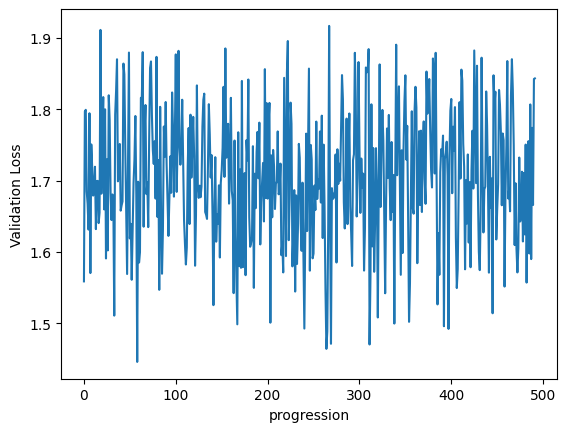

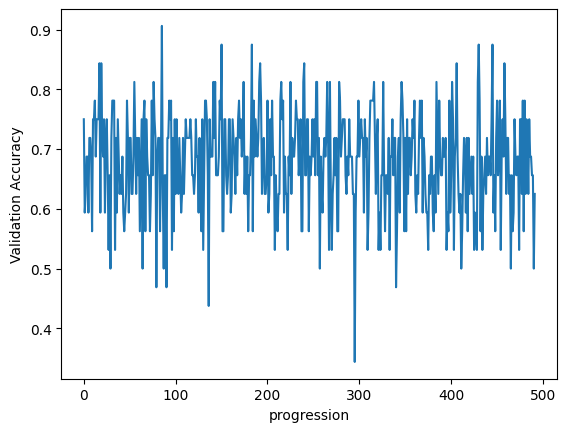

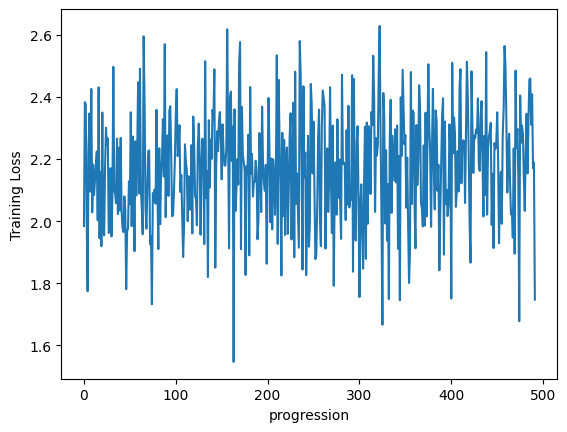

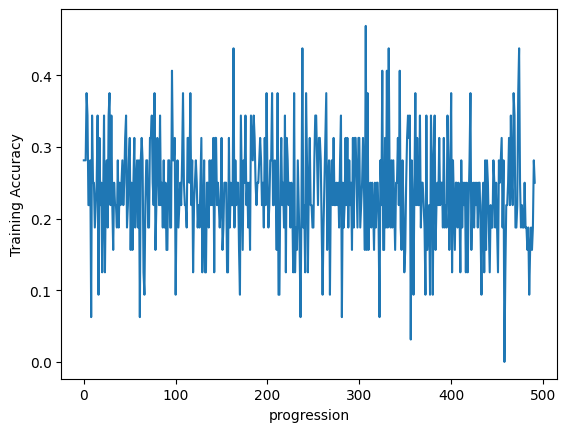

In [ ]:
import matplotlib.pyplot as plt

plt.plot(valid_loss_asan)
plt.xlabel('progression')
plt.ylabel('Validation Loss')
plt.show()

plt.plot(valid_accs_asan)
plt.xlabel('progression')
plt.ylabel('Validation Accuracy')
plt.show()

plt.plot(train_loss_asan)
plt.xlabel('progression')
plt.ylabel('Training Loss')
plt.show()

plt.plot(train_accs_asan)
plt.xlabel('progression')
plt.ylabel('Training Accuracy')
plt.show()

In [ ]:
train 86.34
valid 7177
test 7332

MLP(
  (fc1): Linear(in_features=6144, out_features=2048, bias=True)
  (batchNorm1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): Swish()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (batchNorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): Swish()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (batchNorm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (batchNorm4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (batchNorm5): BatchNorm1d(128, eps=1e-

In [ ]:
def load_model(model, model_path, num_classes=12):
    model = MLP(embedding_dim, num_classes)
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))  # 使用CPU加载模型

    # 获取模型的状态字典
    state_dict = checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint

    # 创建一个新的状态字典，只保留与模型匹配的键
    model_state_dict = model.state_dict()
    state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}

    # 加载状态字典到模型中，strict=False 可以处理缺失或意外的键
    model.load_state_dict(state_dict, strict=False)

    model.eval()  # 设置模型为评估模式
    return model

# 用法
model_path = '/content/drive/MyDrive/Swarnava/asanEmb_model.pth'  # 指向保存的模型检查点的路径
Globals.model = load_model(Globals.model,model_path)

In [ ]:
for embs, labels in ISICEmbTestLoader2:
    output=softmax_model(embs)
    acc=calc_accuracy(output, labels)
    print(output)
    print(labels)
    print(acc)


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 2048])

In [ ]:
import tqdm
E_scores=[]
calib_labels=[]

softmax_model=MLPwithSoftMax(Globals.model).eval().to(device)

for emb,label in tqdm.tqdm(ISICEmbCalibLoader):
    emb=emb.to(device)
    output=softmax_model(emb)
    e=output[[0]]
    E_scores.append(e)
    calib_labels.append(label.item())

    emb=emb.cpu()
    del emb
    torch.cuda.empty_cache()




100%|██████████| 781/781 [00:03<00:00, 203.06it/s]


In [ ]:
print(len(calib_split))

1488


In [ ]:
E_values = [e[0] for e in E_scores]
for i in range(len(E_values)):
    E_scores[i] = (E_values[i][calib_labels[i]])
    print(E_scores[i])

tensor(0.0784, grad_fn=<SelectBackward0>)
tensor(0.0806, grad_fn=<SelectBackward0>)
tensor(0.0921, grad_fn=<SelectBackward0>)
tensor(0.0806, grad_fn=<SelectBackward0>)
tensor(0.0893, grad_fn=<SelectBackward0>)
tensor(0.0817, grad_fn=<SelectBackward0>)
tensor(0.0879, grad_fn=<SelectBackward0>)
tensor(0.0806, grad_fn=<SelectBackward0>)
tensor(0.0896, grad_fn=<SelectBackward0>)
tensor(0.0806, grad_fn=<SelectBackward0>)
tensor(0.0879, grad_fn=<SelectBackward0>)
tensor(0.0806, grad_fn=<SelectBackward0>)
tensor(0.0806, grad_fn=<SelectBackward0>)
tensor(0.0788, grad_fn=<SelectBackward0>)
tensor(0.0892, grad_fn=<SelectBackward0>)
tensor(0.0767, grad_fn=<SelectBackward0>)
tensor(0.0806, grad_fn=<SelectBackward0>)
tensor(0.0896, grad_fn=<SelectBackward0>)
tensor(0.0879, grad_fn=<SelectBackward0>)
tensor(0.0805, grad_fn=<SelectBackward0>)
tensor(0.0943, grad_fn=<SelectBackward0>)
tensor(0.0817, grad_fn=<SelectBackward0>)
tensor(0.0788, grad_fn=<SelectBackward0>)
tensor(0.0767, grad_fn=<SelectBack

In [ ]:
import math
E_scores = torch.tensor(E_scores)
E_sorted, _ = torch.sort(E_scores)
q_hat = math.ceil((1489)*0.3)/1488
E_10 = torch.quantile(E_sorted, q_hat)
print(E_10)

tensor(0.0830)


In [ ]:
label_sets = {num: set() for num in range(len(test_data))}
count = 0
for emb,label in tqdm.tqdm(ISICEmbTestLoader2):
    emb = emb.to(device)
    output = softmax_model(emb)
    sum=0
    for i in range(len(output[0])):
        if(sum<E_10):
            sum+=output[0][i]
            label_sets[count].add(i)
    count+=1

100%|██████████| 2447/2447 [00:16<00:00, 148.09it/s]


In [ ]:
print(label_sets)

difficulty_index_1 = []
difficulty_index_2 = []
difficulty_index_3 = []
difficulty_index_4 = []
empty = []

count=0
empty_count=0
for label_set in label_sets.values():
    if(len(label_set)==1):
        difficulty_index_1.append(count)
    count+=1

for label_set in label_sets.values():
    if(len(label_set)==2):
        difficulty_index_2.append(count)
    count+=1

for label_set in label_sets.values():
    if(len(label_set)==3):
        difficulty_index_3.append(count)
    count+=1

for label_set in label_sets.values():
    if(len(label_set)>3):
        difficulty_index_4.append(count)
    count+=1

for label_set in label_sets.values():
    if(len(label_set)==0):
        empty.append(empty_count)
    empty_count+=1
print(len(difficulty_index_1))
print(len(difficulty_index_2))
print(len(difficulty_index_3))
print(len(difficulty_index_4))
print(len(empty))


{0: {0}, 1: {0}, 2: {0}, 3: {0}, 4: {0}, 5: {0}, 6: {0}, 7: {0}, 8: {0}, 9: {0}, 10: {0}, 11: {0}, 12: {0}, 13: {0}, 14: {0}, 15: {0}, 16: {0}, 17: {0}, 18: {0}, 19: {0}, 20: {0}, 21: {0}, 22: {0}, 23: {0}, 24: {0}, 25: {0}, 26: {0}, 27: {0}, 28: {0}, 29: {0}, 30: {0}, 31: {0}, 32: {0}, 33: {0}, 34: {0}, 35: {0}, 36: {0}, 37: {0}, 38: {0}, 39: {0}, 40: {0}, 41: {0}, 42: {0}, 43: {0}, 44: {0}, 45: {0}, 46: {0}, 47: {0}, 48: {0}, 49: {0}, 50: {0}, 51: {0}, 52: {0}, 53: {0}, 54: {0}, 55: {0}, 56: {0}, 57: {0}, 58: {0}, 59: {0}, 60: {0}, 61: {0}, 62: {0}, 63: {0}, 64: {0}, 65: {0}, 66: {0}, 67: {0}, 68: {0}, 69: {0}, 70: {0}, 71: {0}, 72: {0}, 73: {0}, 74: {0}, 75: {0}, 76: {0}, 77: {0}, 78: {0}, 79: {0}, 80: {0}, 81: {0}, 82: {0}, 83: {0}, 84: {0}, 85: {0}, 86: {0}, 87: {0}, 88: {0}, 89: {0}, 90: {0}, 91: {0}, 92: {0}, 93: {0}, 94: {0}, 95: {0}, 96: {0}, 97: {0}, 98: {0}, 99: {0}, 100: {0}, 101: {0}, 102: {0}, 103: {0}, 104: {0}, 105: {0}, 106: {0}, 107: {0}, 108: {0}, 109: {0}, 110: {0},

166
254
250
1777
0
340
395
331
1381
0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from matplotlib.backends.backend_pdf import PdfPages

def plot_multiclass_roc(y_true, y_score, num_classes, class_names, pdf_filename):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class')
    plt.legend(loc="lower right")

    # 保存为PDF
    pdf_pages = PdfPages(pdf_filename)
    pdf_pages.savefig()
    pdf_pages.close()

100%|██████████| 40/40 [00:01<00:00, 20.32it/s]


Class ak - Accuracy: 0.5645, F1 Score: 0.5147, Recall: 0.5645
Class bcc - Accuracy: 0.7091, F1 Score: 0.7059, Recall: 0.7091
Class dermatofibroma - Accuracy: 0.8017, F1 Score: 0.7623, Recall: 0.8017
Class hemangioma - Accuracy: 0.6145, F1 Score: 0.5604, Recall: 0.6145
Class intraepithelial carcinoma - Accuracy: 0.3774, F1 Score: 0.4545, Recall: 0.3774
Class lentigo - Accuracy: 0.6735, F1 Score: 0.6735, Recall: 0.6735
Class melanoma - Accuracy: 0.6271, F1 Score: 0.7327, Recall: 0.6271
Class nevus - Accuracy: 0.7725, F1 Score: 0.8108, Recall: 0.7725
Class pyogenic granuloma - Accuracy: 0.8378, F1 Score: 0.8378, Recall: 0.8378
Class scc - Accuracy: 0.5656, F1 Score: 0.5349, Recall: 0.5656
Class sebk - Accuracy: 0.5859, F1 Score: 0.5498, Recall: 0.5859
Class wart - Accuracy: 0.7828, F1 Score: 0.7692, Recall: 0.7828


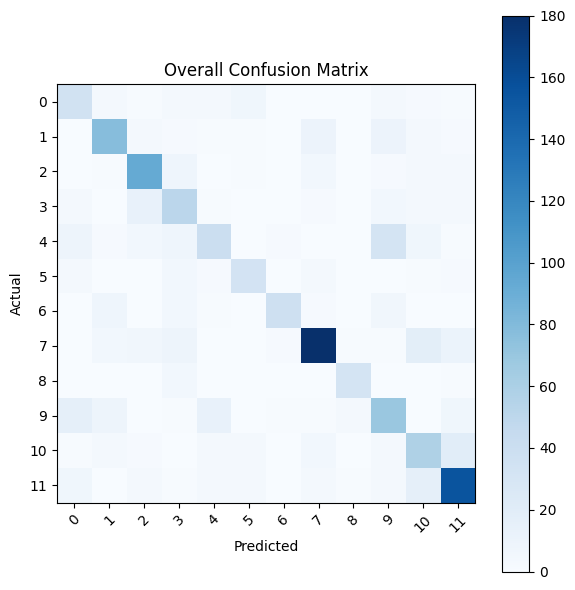

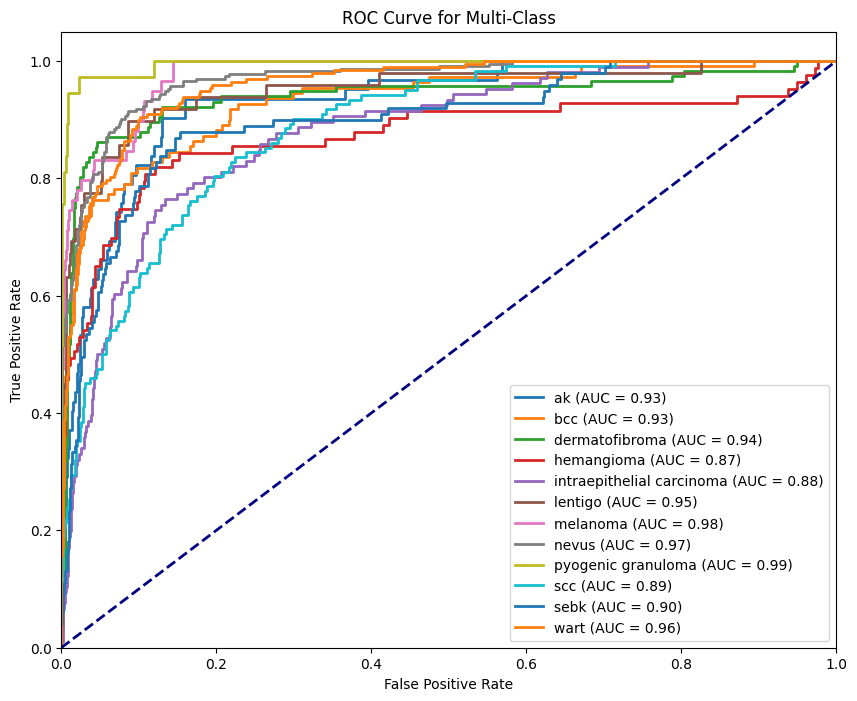

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import label_binarize
import tqdm

@torch.no_grad()
def test_all_classes(model, dataloader):
    model.eval()
    class_correct = [0] * num_classes  # 用于记录每个类别的正确预测数
    class_total = [0] * num_classes  # 用于记录每个类别的总样本数

    all_true_labels = []
    all_pred_labels = []
    all_scores = []  # 存储模型的输出分数矩阵

    confusion_matrices = []  # 存储每个类别的混淆矩阵

    for images, labels in tqdm.tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels = labels.cpu().numpy()
        pred_labels = predicted.cpu().numpy()

        all_true_labels.extend(true_labels)
        all_pred_labels.extend(pred_labels)


        scores = outputs.cpu().numpy()
        all_scores.extend(scores)


        for i in range(len(labels)):
            label = true_labels[i]
            pred = pred_labels[i]
            class_correct[label] += (pred == label)
            class_total[label] += 1

        # 计算混淆矩阵并添加到列表中
        cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(num_classes))
        confusion_matrices.append(cm)

    # 生成整体混淆矩阵
    overall_confusion_matrix = np.sum(confusion_matrices, axis=0)

    # 保存整体混淆矩阵为PDF
    pdf_pages_confusion = PdfPages("overall_confusion_matrix.pdf")
    plt.figure(figsize=(6, 6))
    plt.imshow(overall_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Overall Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, np.arange(num_classes), rotation=45)
    plt.yticks(tick_marks, np.arange(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    pdf_pages_confusion.savefig()
    pdf_pages_confusion.close()

    for i in range(num_classes):
        class_name = int_to_classes_asan[i]
        accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0

        # 计算F1分数
        f1 = f1_score(all_true_labels, all_pred_labels, labels=[i], average='weighted')

        # 计算召回率
        recall = recall_score(all_true_labels, all_pred_labels, labels=[i], average='weighted')

        print(f"Class {class_name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

    y_true_binary = label_binarize(all_true_labels, classes=np.arange(num_classes))

     # 获取类别名称
    class_names = [int_to_classes_asan[i] for i in range(num_classes)]

    return y_true_binary, np.array(all_scores), class_names



# 调用函数测试所有类别
# 调用函数获取真实标签和模型分数
# 调用函数获取真实标签和模型分数
y_true_binary, scores, class_names = test_all_classes(Globals.model, ISICEmbTestLoader)

# 调用绘制ROC曲线函数 # 请确保设置正确的类别数量
# 调用函数绘制多类别ROC曲线并保存为PDF
pdf_filename = "multiclass_roc_curve.pdf"
plot_multiclass_roc(y_true_binary, scores, num_classes, class_names, pdf_filename)